In [1]:
%matplotlib widget

import gc 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import os
from xmitgcm import open_mdsdataset
from xmitgcm.utils import get_grid_from_input, get_extra_metadata
import xgcm
from scipy.interpolate import interp1d

from myutils import *
from MITgcmutils import llc
import xarray as xr
import cmocean.cm as cmo
#import cartopy.crs as ccrs
import cartopy as cart

def sq(a):
    import numpy as np
    a = np.squeeze(a)
    masked_array=np.ma.masked_where(a==0., a)
    return masked_array

def mosaic_llc(field):
    return np.vstack([np.hstack([np.vstack([np.rot90(field[i]) for i in [9,8,7]]),
                                 np.vstack([np.rot90(field[i]) for i in [12,11,10]]),
                                 np.vstack([field[i] for i in [0,1,2]]),
                                 np.vstack([field[i] for i in [3,4,5]])]),
                      np.hstack([np.rot90(field[6])*np.tri(90)[::-1,:],np.triu(np.rot90(field[6],k=2))*np.tri(90)[::-1,:],
                                 np.triu(np.rot90(field[6],k=-1)),np.zeros(field[6].shape)])])[30:315,:]

def llc13to5faces(field):
    """
    fld = llc13to5faces(field) returns a list of 5 faces constructed from 
    the input of a 13-faces field as returned from 
    xmitgcm.open_mdsdataset(...,geometry='llc')
    """
    return [np.vstack((field[0,...],field[1,...],field[2,...])),
            np.vstack((field[3,...],field[4,...],field[5,...])),
            field[6,...],
            np.hstack((field[7,...],field[8,...],field[9,...])),
            np.hstack((field[10,...],field[11,...],field[12,...]))]

def symNorm(vmax):
    import matplotlib.colors as mcolors
    return mcolors.Normalize(vmin=-vmax,vmax=vmax)

face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

def flat2d(x):
    if type(x) is np.ndarray:
        x0 = np.concatenate( [np.concatenate([x[:,0,:,:],x[:,1,:,:],x[:,2,:,:]], axis=-2),
                              np.concatenate([x[:,3,:,:],x[:,4,:,:],x[:,5,:,:]], axis=-2)], axis=-1 )
        y0 = np.concatenate( [np.concatenate([x[:,7,:,:],x[:,8,:,:],x[:,9,:,:]], axis=-1),
                              np.concatenate([x[:,10,:,:],x[:,11,:,:],x[:,12,:,:]], axis=-1)], axis=-2 )
    else:
        x0 = xr.concat( [xr.concat( [x.isel(face=0),x.isel(face=1),x.isel(face=2)], dim = 'j' ),
                         xr.concat( [x.isel(face=3),x.isel(face=4),x.isel(face=5)], dim = 'j' )], dim='i' )
        y0 = xr.concat( [xr.concat( [x.isel(face=7),x.isel(face=8),x.isel(face=9)], dim = 'i' ),
                         xr.concat( [x.isel(face=10),x.isel(face=11),x.isel(face=12)], dim = 'i' )], dim='j' )
    return np.concatenate((x0,np.rot90(y0,k=1,axes=(-2,-1))), axis=-1)

def calc_drake_passage_transport(ds):
    vtrans = (ds.VVEL*ds.hFacS*ds.drF).sum('k')*ds.dxG * 1e-6
    return (vtrans.sel(face=11,i=range(87,90),j_g=62).sum('i') + vtrans.sel(face=12,i=range(20),j_g=62).sum('i'))

def make_masks(coords):
    global_mask = coords.hFacC.isel(k=0)
    global_mask[6,:,:]=0. # delete Arctic face
    global_mask[2,80:,60:]=0.
    global_mask[7,:,:13]=0.
    global_mask[10,:43,:11]=0.
    # remove Hudson
    global_mask[10,30:54,5:39] = 0.
    global_mask[10,30:62,10:39] = 0.
    #
    atlantic_mask = global_mask.where(coords.YC>-35).where( # Southern Ocean
        np.logical_and(coords.XC<20,coords.XC>-98)).where( # most of the non-Atlantic Ocean
        np.logical_or(coords.XC<0,np.logical_or(coords.YC<30,coords.YC>47))).where(
        np.logical_or(coords.XC<-9,np.logical_or(coords.YC<34,coords.YC>38))).where( # Strait of Gibraltar
        np.logical_or(coords.XC>-70,coords.YC>9)).where( # East Pacific
        np.logical_or(coords.XC>-84,coords.YC>14)).where( # Isthmus of Panama etc.
        np.logical_or(coords.XC>-90,coords.YC>18)).where(
        np.logical_or(coords.XC>-70,coords.YC<50)).fillna(0)
    indopacific_mask = (global_mask-atlantic_mask).where(
        np.logical_and(coords.YC>-35,coords.YC<70)).fillna(0)
    # remove Hudson
    indopacific_mask[10,10:,:39] = 0.
    # remove Med and parts of Arctic
    indopacific_mask[ 2,20:,29:84] = 0.
    # remove Bering strait and Chukchy Sea
    indopacific_mask[ 7,:,:14] = 0.
    return global_mask, atlantic_mask, indopacific_mask

def zonal_mean(ds,fld,msk):
    # mask the Med
    dvol = flat2d(ds.hFacC*ds.rA*ds.drF*msk)
    # mask the Med
    dvol[:,200:217,33:80]=0
    dvol[:,217:222,40:60]=0
    ra = dvol.sum(axis=-1)
    ra[ra==0]=np.Inf
    fldz = (flat2d(fld)*dvol).sum(axis=-1)/ra
    return np.ma.masked_array(fldz,fldz==0)

def compute_moc(wflux):
    u0 = xr.concat( [xr.concat( [wflux.isel(face=0),wflux.isel(face=1),wflux.isel(face=2)], dim = 'j' ),
                     xr.concat( [wflux.isel(face=3),wflux.isel(face=4),wflux.isel(face=5)], dim = 'j' )], dim='i' )
    v0 = xr.concat( [xr.concat( [wflux.isel(face=7),wflux.isel(face=8),wflux.isel(face=9)], dim = 'i' ),
                     xr.concat( [wflux.isel(face=10),wflux.isel(face=11),wflux.isel(face=12)], dim = 'i' )], dim='j' )
    wflx = (np.concatenate((u0,np.rot90(v0,k=1,axes=(-2,-1))), axis=-1)).sum(axis=-1)
    # order of integration: from north to south because of Atlantic MOC, requires sign change
    mocstrf = -np.flip(np.flip(wflx,axis=-1).cumsum(axis=-1),axis=-1)
    mocstrf[wflx==0]=0.
    return mocstrf

def compute_moc_layers(dl,msk):

    locmsk = msk.values
    ufx = dl.LaUH1RHO*dl.dyG*locmsk
    vfx = dl.LaVH1RHO*dl.dxG*locmsk
    # integration over longitude
    vf =  xr.concat([vfx.isel(face= 0),vfx.isel(face= 1),vfx.isel(face= 2)],dim='j_g').sum(dim='i') \
        + xr.concat([vfx.isel(face= 3),vfx.isel(face= 4),vfx.isel(face= 5)],dim='j_g').sum(dim='i')
    uf =  xr.concat([ufx.isel(face= 7),ufx.isel(face= 8),ufx.isel(face= 9)],dim='i_g').sum(dim='j') \
        + xr.concat([ufx.isel(face=10),ufx.isel(face=11),ufx.isel(face=12)],dim='i_g').sum(dim='j')
    uvf = vf.data[:,1:]-uf.data[:,:0:-1]
    # add a column of zeros at the southern end
    uvf = np.hstack((np.zeros((uvf.shape[0],1)),uvf))
    # integration over depth
    return np.cumsum(uvf,axis=0)

def calc_flux_divergence(dl):
    grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)
    # layer flux in two directions
    flxx = dl.LaUH1RHO*dl.dyG
    flxy = dl.LaVH1RHO*dl.dxG
    # difference in the x and y directions
    diff_flx = grd.diff_2d_vector({'X': flxx, 'Y': flxy}, boundary='fill')
    # divergence
    return diff_flx['X'] + diff_flx['Y']

def calc_wflux_dia(dl):
    flx_div = calc_flux_divergence(dl)
    return -flx_div.reindex(l1_c=flx_div.l1_c[::-1]).cumsum(dim='l1_c')

def compute_moc_layers_div(dl,msk):

    # grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)
    # # compute divergence of layer flux
    # flxx = dl.LaUH1RHO*dl.dyG
    # flxy = dl.LaVH1RHO*dl.dxG
    # # difference in the x and y directions
    # diff_flx = grd.diff_2d_vector({'X': flxx, 'Y': flxy}, boundary='fill')
    # # convergence
    # divergence = diff_flx['X'] + diff_flx['Y']
    divergence = calc_flux_divergence(dl)
    # vertical integral (from bottom to top)
    wflux = -divergence.reindex(l1_c=divergence.l1_c[::-1]).cumsum(dim='l1_c')
    # add the masking here after re-reindexing
    return compute_moc(wflux.reindex(l1_c=wflux.l1_c[::-1])*msk)

def compute_layers(dl,msk):
    grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)
    lahc = grd.interp_2d_vector({'X': dl.LaHw1RHO,
                                 'Y': dl.LaHs1RHO},
                                 to = 'center', boundary='fill')
    lath = 0.5*(lahc['X']+lahc['Y'])*msk
#    lath = lath.where(msk>0.)
    u0 = xr.concat([xr.concat([lath.isel(face=0),
                               lath.isel(face=1),
                               lath.isel(face=2)], dim='j' ),
                    xr.concat([lath.isel(face=3),
                               lath.isel(face=4),
                               lath.isel(face=5)], dim='j' )], dim='i')
    v0 = xr.concat([xr.concat([lath.isel(face=7),
                               lath.isel(face=8),
                               lath.isel(face=9)], dim='i' ),
                    xr.concat([lath.isel(face=10),
                               lath.isel(face=11),
                               lath.isel(face=12)],dim='i')],dim='j')
    zz = np.concatenate((u0,np.rot90(v0,k=1,
                                     axes=(-2,-1))), axis=-1).cumsum(axis=0)
    return zz.mean(axis=-1,where=zz!=0)

def plot2dmap(ax,fld,levs,tstr='dummy',cmap=None):
    
    ax.set_global()
    # for iface in [0,1,2,3,4,5,6,7,8,9,10,11,12]:
    # for iface in [0,1,2,3,4,5,10,11,12]:
    for iface in range(13):
        if iface==12: 
            clrbr=True
            # cbarargs={"orientation": "horizontal"}
            cbarargs={"extend": "both", "orientation": "horizontal"}
            if levs.vmin==0.: 
                cbarargs["extend"] = "max"
        else:
            clrbr=False
            cbarargs=None

        fld.isel(face=iface).plot.pcolormesh(ax=ax, transform=cart.crs.PlateCarree(), x="XC", y="YC", norm=levs,
                                             add_colorbar=clrbr, cmap=cmap, cbar_kwargs=cbarargs)
    
    ax.set_title('%s'%(tstr))
    ax.coastlines()
    ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    ax.gridlines()
    
def colorbar(mappable, **plt_kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, **plt_kwargs)
    plt.sca(last_axes)
    return cbar

In [2]:
import pyresample

class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)

    def __call__(self, da, ax=None, lon_0=-60, tstr=None, **plt_kwargs):

        assert set(da.dims) == set(['face', 'j', 'i']), "da must have dimensions ['face', 'j', 'i']"

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)

        x,y = self.new_grid_lon, self.new_grid_lat

        p = ax.pcolormesh(x, y, field, transform=cart.crs.PlateCarree(), **plt_kwargs)


        # ax.coastlines()
        # ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
        ax.add_feature(cart.feature.LAND, facecolor='0.7', zorder=3)
        ax.gridlines()

        if tstr is not None:
            ax.set_title('%s'%(tstr))
            
        label = None
        # if da.name is not None:
        #     label = da.name
        # if 'units' in da.attrs:
        #     label += ' (%s)' % da.attrs['units']
        cbarextend='both'
        try:
            mynorm = plt_kwargs.pop('norm')
            if mynorm.vmin == 0.: cbarextend='max'
        except:
            cbarextend='both'

        shrinkfac=1.
        cb = plt.colorbar(p, ax=ax, shrink=shrinkfac, label=label, extend=cbarextend, orientation='horizontal')

        return ax

In [3]:
# We generate the extra metadata needed for multi-faceted grids
llc90_extra_metadata = get_extra_metadata(domain='llc', nx=90)
grid = get_grid_from_input(os.path.join('/home/ollie/mlosch/MITgcm/nils/llc90/input','tile<NFACET>.mitgrid'),
                           geometry='llc', extra_metadata=llc90_extra_metadata)

In [4]:
deltat=1800.
ny, nx = 1170, 90
# prefix=['diagsKrN2']

prefixmonthly = ['diags2DMonthly']

bdir='/work/ollie/mlosch/idemix_test/llc90'
gdir='/work/ollie/mlosch/idemix_test/llc90/grid'
fdir='/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs'

rname0='run12'; deltat0 = 3600.
rname1='run13'; deltat1 = 3600.
rname2='run14'; deltat2 = 3600.

rnames= [rname0,rname1,rname2]
deltats= [deltat0,deltat1,deltat2]

rdirs = []
for rname in rnames:
    rdirs.append(os.path.join(bdir,rname))

rdirs

['/work/ollie/mlosch/idemix_test/llc90/run12',
 '/work/ollie/mlosch/idemix_test/llc90/run13',
 '/work/ollie/mlosch/idemix_test/llc90/run14']

In [12]:
# find out the file numbers to read
cycle = 5
startyear = 1958
refdate = "%i-1-1 0:0:0"%(startyear-(cycle-1)*62)
rdirs[1]

'/work/ollie/mlosch/idemix_test/llc90/run13'

In [13]:
dls = [open_mdsdataset(rdir,prefix='diagsLAYERS', 
                       delta_t=deltats[k],ref_date=refdate,geometry='llc')
       for k,rdir in enumerate(rdirs)]

In [15]:
d00=dls[2]
coords = d00.coords.to_dataset().reset_coords()
grd = xgcm.Grid(coords, periodic=False, face_connections=face_connections)
#
coords['XC'] = grid.XC
coords['YC'] = grid.YC
coords['XG'] = grid.XG
coords['YG'] = grid.YG
myiters=list(dls[-1].iter.values)
print("available output slices %i, years %s to %s"%(len(myiters),
    d00.time[0].data.astype('datetime64[Y]'),d00.time[-1].data.astype('datetime64[Y]')))
# print(coords['XG'])

available output slices 46, years 1958 to 2003


In [16]:
k=2
d03 = open_mdsdataset(rdirs[k],prefix=['diags3D'],delta_t=deltats[k],ref_date=refdate,geometry='llc')
coords = d03.coords.to_dataset().reset_coords()
grd = xgcm.Grid(coords, periodic=False, face_connections=face_connections)

# fix coordinates
d03.coords['XC'] = grid.XC
d03.coords['YC'] = grid.YC
d03.coords['XG'] = grid.XG
d03.coords['YG'] = grid.YG
#coords = d06.coords.to_dataset().reset_coords()

myiters=list(d03.iter.values)
print("available output slices %i, years %s to %s"%(len(myiters),
    d03.time[0].data.astype('datetime64[Y]'),d03.time[-1].data.astype('datetime64[Y]')))

available output slices 293, years 1711 to 2003


In [17]:
#dss[k]=d03

In [8]:
d10 = open_mdsdataset('/work/ollie/mlosch/idemix_test/llc90/run10',prefix=['diags2D','diags3D'],
                      delta_t=3600,ref_date=refdate,geometry='llc')

In [19]:
dss = [open_mdsdataset(rdir,prefix=['diags2D','diags3D'], iters=myiters,
                       delta_t=deltats[k],ref_date=refdate,geometry='llc') #,extra_metadata=llc90_extra_metadata)
       for k,rdir in enumerate(rdirs)]
coords = dss[0].coords.to_dataset().reset_coords()
grd = xgcm.Grid(coords, periodic=False, face_connections=face_connections)

# # fix coordinates
# for ds in dss:
#     ds.coords['XC'] = grid.XC
#     ds.coords['YC'] = grid.YC
#     ds.coords['XG'] = grid.XG
#     ds.coords['YG'] = grid.YG

In [20]:
#dss.insert(0,d10)

In [23]:
# fix coordinates
for ds in dss:
    ds.coords['XC'] = grid.XC
    ds.coords['YC'] = grid.YC
    ds.coords['XG'] = grid.XG
    ds.coords['YG'] = grid.YG
    
coords = dss[0].coords.to_dataset().reset_coords()

In [24]:
print(dss)

[<xarray.Dataset>
Dimensions:               (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50, k_p1: 51, face: 13, l1_b: 89, l1_c: 88, l1_i: 87, time: 293)
Coordinates: (12/51)
  * i                     (i) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i_g                   (i_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * j                     (j) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * j_g                   (j_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * k                     (k) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * k_u                   (k_u) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
    ...                    ...
    dyU                   (face, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    layer_1RHO_bounds     (l1_b) >f4 dask.array<chunksize=(89,), meta=np.ndarray>
    layer_1RHO_center     (l1_c) float32 dask.array<chunksize=(88,), meta=np.ndarray>
    layer_1RHO_interface  (l1_i) >f4 dask.

In [ ]:
from matplotlib import cm

plt.close('all')
#proj=cart.crs.Robinson()#central_longitude=180.0-19) #central_longitude=7.0)
proj=cart.crs.EqualEarth()#central_longitude=180.0-19) #central_longitude=7.0)


mapper = LLCMapper(coords) #, dx=1., dy=1.)
mask2d=(dss[0].hFacC.isel(k=0)!=0.).compute()

fig, ax = plt.subplots(nrows=2,ncols=3,sharex=True,sharey=True,figsize=(24,12),subplot_kw={'projection': proj})

ax = ax.flatten()

mytime=-1
mlnorm = colors.Normalize(vmin=0,vmax=1000)
enorm = colors.Normalize(vmin=-3,vmax=2)


for k in range(3):
    mapper(dss[k].isel(time=mytime).MXLDEPTH.where(mask2d),ax=ax[k],norm=mlnorm,cmap=cmo.dense,tstr=rnames[k]+': MLD (m)')
    # mapper(dss[k].isel(time=mytime).MXLDEPTH.where(mask2d),ax=ax[k],norm=mlnorm,cmap=cmo.dense,tstr=rnames[k]+': MLD (m)')
    # mapper(dss[k].isel(time=mytime).MXLDEPTH.where(mask2d),ax=ax[k],norm=mlnorm,cmap=cmo.dense,tstr=rnames[k]+': MLD (m)')

for k in range(3):
    mapper(dss[k].isel(time=mytime).ETAN.where(mask2d),ax=ax[k+3],norm=enorm,cmap=cm.jet,tstr=rnames[k]+': EtaN (m)')

#dmlnorm = colors.Normalize(vmin=-100,vmax=100)
#mapper((dss[0]-dss[1]).isel(time=mytime).MXLDEPTH.where(mask2d),ax=ax[4],norm=dmlnorm,cmap=cmo.delta,tstr='%s - %s: MLD(md)'%(rnames[0],rnames[1]))

In [ ]:
mocstrf=[]
dp=[]

if True:
    global_mask, atlantic_mask, indopacific_mask = make_masks(coords)
    for k,ds in enumerate(dss):
        rname=rnames[k]
        print("stream functions: processing %s"%rname)
        mocstrf.append(compute_moc(ds.WVEL*(ds.rA*atlantic_mask)*1e-6))
#        mocstrf[k].tofile(os.path.join(postprocdir,"amocstrf_%s.bin"%(rname)))
        print("drake passage transports: processing %s"%rname)
        dp.append(calc_drake_passage_transport(ds).values)
#        dp[k].tofile(os.path.join(postprocdir,"drake_passage_transp_%s.bin"%(rname)))



In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2,sharex=True,figsize=(18,6))
#plt.clf()
y = flat2d(grid.YC).mean(axis=-1)
iz = 22 # blow 500m
iy = 165 # northern hemisphere
labs=['--','-','-.',':']
for k, ds in enumerate(dss):
    #ax[0].plot(ds.time,mocstrf[k][:,iz:,iy:].max(axis=1).max(axis=-1),labs[k],label="%s max"%(rnames[k]))
    # for iy in [195]:
    iy=197
    ax[0].plot(ds.time,mocstrf[k][:,iz:,iy].max(axis=1),labs[k],label=rnames[k])
    # ax[0].plot(ds.time,mocstrf[k][:,iz:,iy].max(axis=1),labs[k],label="%s at %4.1f$^\circ$N"%(rnames[k],y[iy]))
    
    ax[1].plot(ds.time,dp[k],labs[k],label="%s"%(rnames[k]))

ax[0].set_title('AMOC at %4.1f$^\circ$N / Sv'%y[iy])
ax[1].set_title('Drake Passage transport / Sv')

for a in ax:
    a.set_ylabel('Sv')
    a.legend()
    a.grid()
    for x in dss[0].time[0::62]:
        a.axvline(x.data,linestyle='--',color='k')


In [ ]:
d03.time[168],d06.time[-1]

In [10]:
def plotmoc(ax,ds,msk,tstr='dummy'):
    mocstrf = compute_moc(ds.WVEL*(ds.rA*msk)*1e-6)
    yy = flat2d(grid.YC)
    dd = flat2d(ds.Depth*msk)
    d = dd.max(axis=-1)
    y = yy.mean(axis=-1)
    #y = np.arange(y.shape[0])
    #csf=ax.pcolormesh(y,ds.Zu,sq(mocstrf),norm=symNorm(20),cmap=cmo.curl)#,vmin=-20,vmax=20)
    csf=ax.contourf(y,ds.Zu,sq(mocstrf),levels=np.linspace(-20,20,41),cmap=cmo.curl, extend='both')
    ax.fill_between(y,-d,-ds.drF.sum()-200,step='mid',facecolor='lightgrey')
    plt.colorbar(csf,ax=ax,orientation='horizontal',extend='both')
    ax.set_title('%s'%(tstr))
    plt.axis('tight')
    plt.grid()

Text(0.5, 0.98, 'Overturning streamfunction $\\Psi$ (Sv), year 2003')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
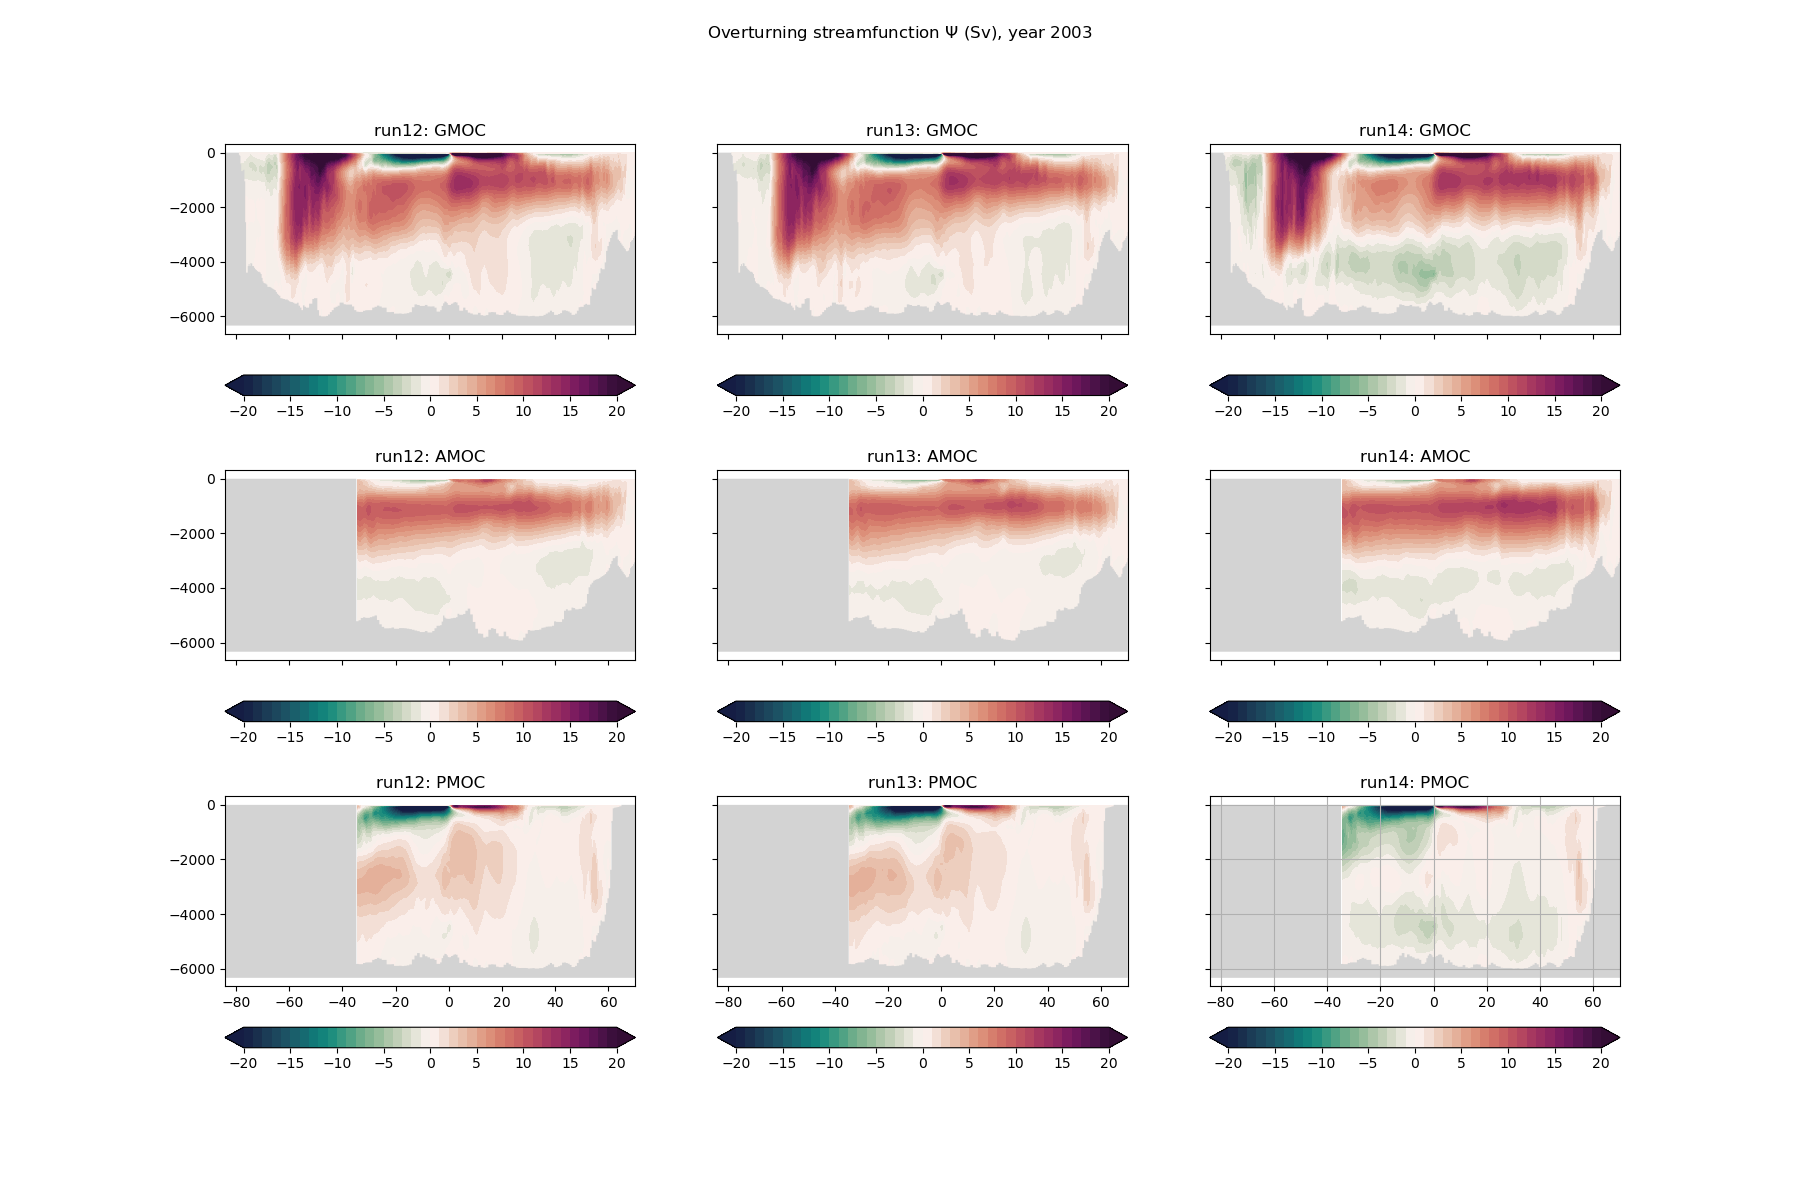

In [25]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)
fig, ax = plt.subplots(nrows=3,ncols=3,sharex=True,sharey=True,figsize=(18,12))#, subplot_kw={'projection': proj})
mytime = -1
#mytime = 208
for k in range(len(dss)):
    dsloc = dss[k].isel(time=mytime)
    plotmoc(ax[0,k],dsloc,     global_mask,tstr=rnames[k]+': GMOC')
    plotmoc(ax[1,k],dsloc,   atlantic_mask,tstr=rnames[k]+': AMOC')
    plotmoc(ax[2,k],dsloc,indopacific_mask,tstr=rnames[k]+': PMOC')

y0,y1 = np.datetime_as_string(dss[0].time.isel(time=0),unit='Y'), np.datetime_as_string(dss[0].time.isel(time=mytime),unit='Y')
fig.suptitle('Overturning streamfunction $\Psi$ (Sv), year %s'%(y1))
#fig.savefig(os.path.join(fdir,'moc_%s_y%s'%(rname0,yearstr)),dpi=300)

In [ ]:
from scipy.interpolate import interp1d
    
def plotmoc_remapped_div(ax,ds,dl,msk,tstr='dummy'):
    mocstrf = compute_moc_layers_div(dl,msk)
    rhoZonalMean = zonal_mean(ds,ds.LaTr1RHO,msk).data
    psir_z = np.zeros(rhoZonalMean.shape)
    # it is cheaper to define the interpolator once and only use part of
    # it than to define a new one for each latitude
    f = interp1d(dl.layer_1RHO_center, mocstrf, axis=0, bounds_error = False, fill_value=0)
    for jj in range(mocstrf.shape[1]):
        psir_z[:,jj] = f(rhoZonalMean[:,jj])[:,jj]

    dd = flat2d(ds.Depth*msk)
    d = dd.max(axis=-1)
    y = xr.concat([coords.YG.isel(face= 0),coords.YG.isel(face= 1),coords.YG.isel(face= 2)], dim='j_g').mean(dim='i_g')
    csf=ax.contourf(y,ds.Z,sq(psir_z)*1e-6,levels=np.linspace(-20,20,41),cmap=cmo.curl, extend='both')
    ylimit=-ds.drF.sum()-200
    ax.fill_between(y,-d,ylimit,step='mid',facecolor='lightgrey')
    ax.set_ylim([ylimit,0])
    plt.colorbar(csf,ax=ax,orientation='horizontal',extend='both')
    ax.set_title('%s'%(tstr))
    ax.grid() 

global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

fig, ax = plt.subplots(nrows=3,ncols=3,sharex=True,sharey=True,figsize=(21,12))#, subplot_kw={'projection': proj})
mytime = -1

for k in range(len(dls)):
    # dsloc = dss[k].isel(time=mytime)
    # dlloc = dls[k].isel(time=mytime)
    dsloc = dss[k].mean(dim='time')
    dlloc = dls[k].mean(dim='time')
    plotmoc_remapped_div(ax[0,k],dsloc,dlloc,     global_mask,tstr=rnames[k]+': GMOC')
    plotmoc_remapped_div(ax[1,k],dsloc,dlloc,   atlantic_mask,tstr=rnames[k]+': AMOC')
    plotmoc_remapped_div(ax[2,k],dsloc,dlloc,indopacific_mask,tstr=rnames[k]+': PMOC')

y0,y1 = np.datetime_as_string(dls[0].time.isel(time=0),unit='Y'), np.datetime_as_string(dls[0].time.isel(time=mytime),unit='Y')
fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s-%s'%(y0,y1))

Text(0.5, 0.98, 'Overturning streamfunction $\\Psi$ (Sv), years 2003')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
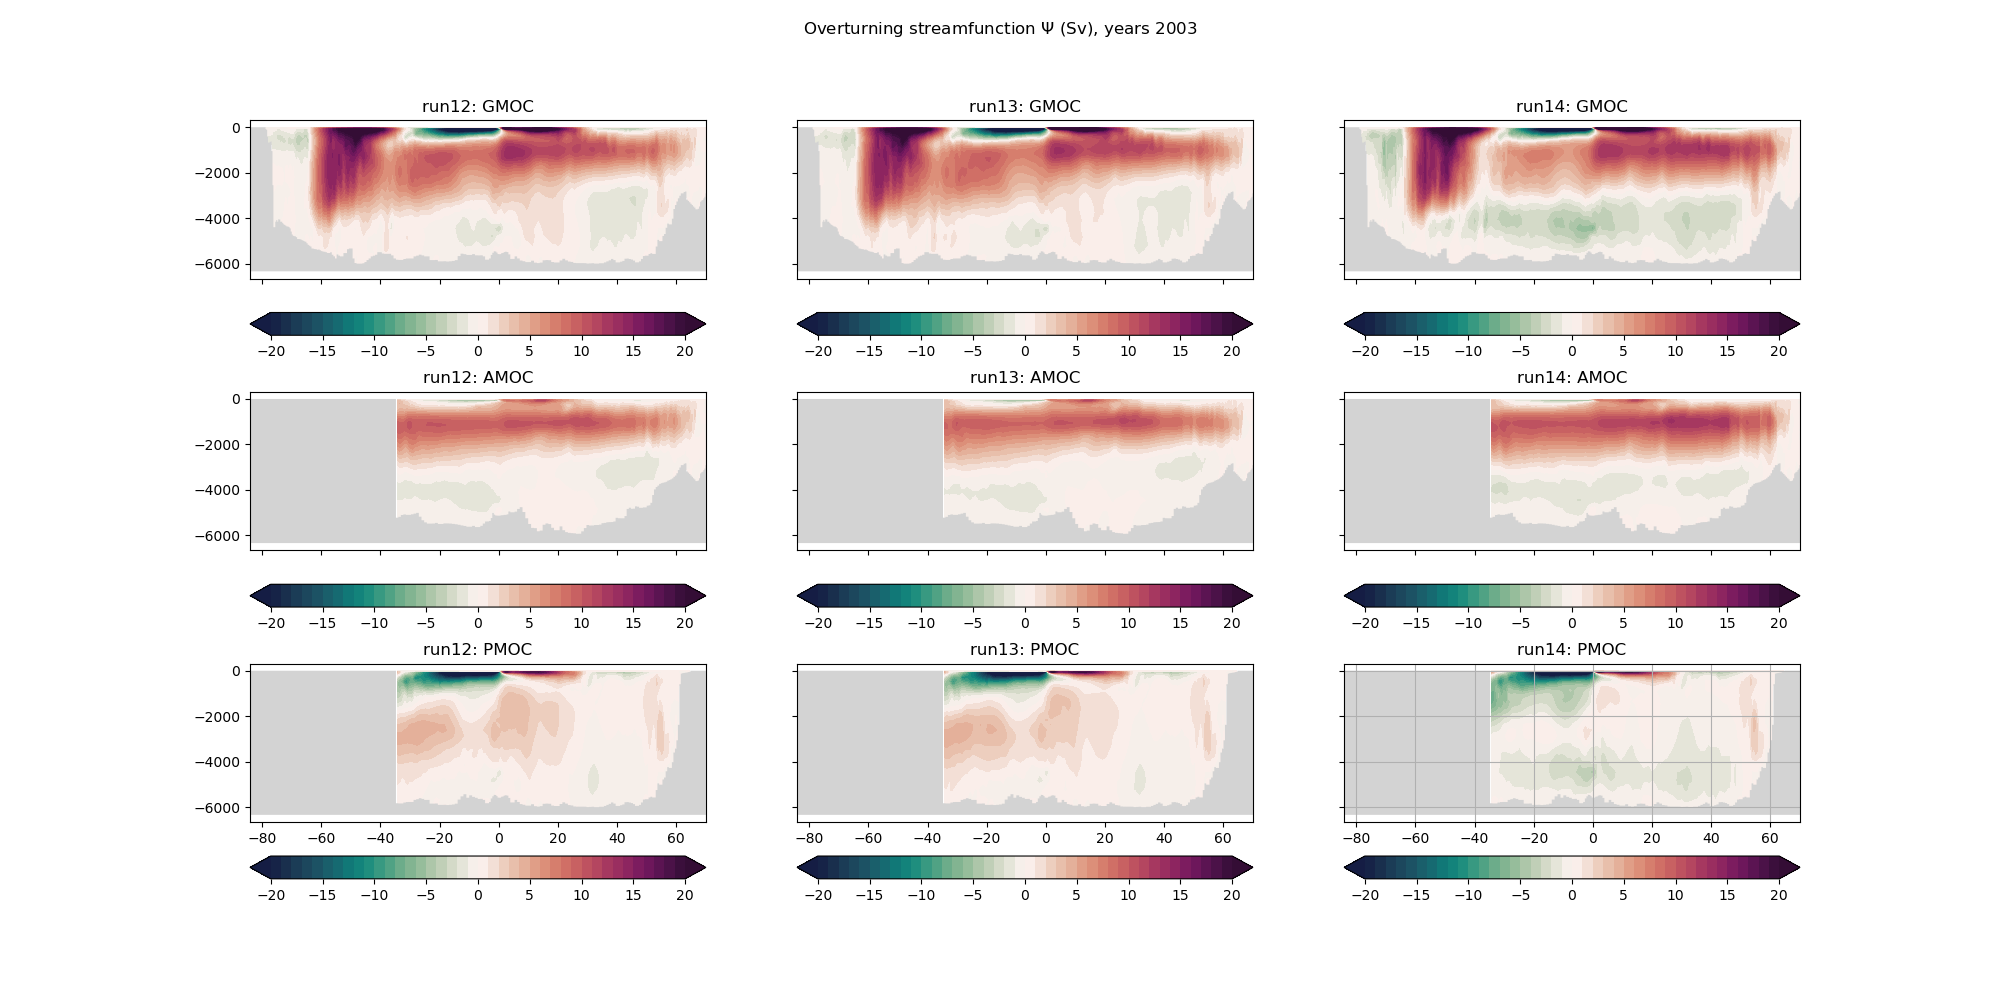

In [27]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)
fig, ax = plt.subplots(nrows=3,ncols=3,sharex=True,sharey=True,figsize=(20,10))#, subplot_kw={'projection': proj})
mytime=-1
for k in range(len(dss)):
    plotmoc(ax[0,k],dss[k].isel(time=mytime),     global_mask,tstr=rnames[k]+': GMOC')
    plotmoc(ax[1,k],dss[k].isel(time=mytime),   atlantic_mask,tstr=rnames[k]+': AMOC')
    plotmoc(ax[2,k],dss[k].isel(time=mytime),indopacific_mask,tstr=rnames[k]+': PMOC')

fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s'%(np.datetime_as_string(dss[0].time.isel(time=mytime), unit='Y')))
#fig.savefig(os.path.join(fdir,'moc_%s_y%s'%(rname0,yearstr)),dpi=300)

In [ ]:
#print(gc.get_threshold())
print("gc.get_count() before garbage collections:")
print(gc.get_count())
gc.collect()
print("gc.get_count() after garbage collections:")
print(gc.get_count())

In [ ]:
dm = open_mdsdataset(rdirs[1],prefix=['diags2D','diags3D'],delta_t=deltat,ref_date="1710-1-1 0:0:0",geometry='llc')
dm.coords['XC'] = grid.XC
dm.coords['YC'] = grid.YC
dm.coords['XG'] = grid.XG
dm.coords['YG'] = grid.YG
dm

In [ ]:
plt.close()
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)
fig, ax = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(21,6))#, subplot_kw={'projection': proj})

dmloc = dm.isel(time=100)
plotmoc(ax[0],dmloc,     global_mask,tstr=rname0+': GMOC')
plotmoc(ax[1],dmloc,   atlantic_mask,tstr=rname0+': AMOC')
plotmoc(ax[2],dmloc,indopacific_mask,tstr=rname0+': PMOC')

fig.suptitle('Overturning streamfunction $\Psi$ (Sv), years %s'%(np.datetime_as_string(dmloc.time, unit='Y')))

In [ ]:
import gc 
gc.collect()

from matplotlib import cm

proj=cart.crs.Robinson(central_longitude=180.0)#-19) #central_longitude=7.0)

mapper = LLCMapper(coords) #, dx=1., dy=1.)
mask2d=(dm.hFacC.isel(k=0)!=0.).compute()

plt.close()
fig, ax = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True,figsize=(16,12),subplot_kw={'projection': proj})

ax = ax.flatten()

mytime=-1
dd = dm
mlnorm = colors.Normalize(vmin=0,vmax=1000)
enorm = colors.Normalize(vmin=-1e-5,vmax=1e-5)

mapper(dd.isel(time=mytime).MXLDEPTH.where(mask2d),ax=ax[0],norm=mlnorm,cmap=cmo.dense,tstr='MLD (m)')
mapper(dd.isel(time=mytime).WVEL.isel(k_l=45).where(mask2d),ax=ax[1],norm=enorm,cmap=cmo.balance,tstr='WVEL (m/s)')
mapper(dd.isel(time=0).MXLDEPTH.where(mask2d),ax=ax[2],norm=mlnorm,cmap=cmo.dense,tstr='MLD (m)')
mapper(dd.isel(time=0).WVEL.isel(k_l=45).where(mask2d),ax=ax[3],norm=enorm,cmap=cmo.balance,tstr='WVEL (m/s)')


fig.suptitle('year %s'%(np.datetime_as_string(dm.time.isel(time=mytime), unit='Y')))
#dmlnorm = colors.Normalize(vmin=-100,vmax=100)
#mapper((dss[0]-dss[1]).isel(time=mytime).MXLDEPTH.where(mask2d),ax=ax[4],norm=dmlnorm,cmap=cmo.delta,tstr='%s - %s: MLD(md)'%(rnames[0],rnames[1]))

In [ ]:
import gc 
gc.collect()
dm.Zl[48].values

In [ ]:
#plt.close('all')
import matplotlib.ticker as mtick
#mytindex = ds1.time.shape[0]-1

def format_func(x,pos):
    mystr = "%1.0e"%x
    return mystr

def plotzonalmean(ax,ds,fld,levs,msk=1.,tstr='dummy',cmap=None):
    # compute zonal mean along grid lines for now:
    y = flat2d(grid.YC).mean(axis=-1)
    fld0 = zonal_mean(ds,fld,msk)
    d = flat2d(ds.Depth*msk).max(axis=-1)
    if 'k_l' in fld.dims:
        # in this case we assume that we want to plot logarithmic color scales
        z = ds.Zl
        tickformat=mtick.LogFormatter()
        useLog=True
        if levs[0]>0:
            cnorm = colors.LogNorm(levs[0],levs[-1])
        else:
            # special trick, when logarithmic levels are negative use symmetric log scale
            cnorm = colors.SymLogNorm(linthresh=np.abs(levs[0]), linscale=2,
                                      vmin=-np.abs(levs[-1]),vmax=np.abs(levs[-1]))        
            levs = np.hstack((np.flip(levs),-levs))
            # cnorm = colors.Normalize(vmin=-np.abs(levs[-1]),vmax=np.abs(levs[-1]))        
            tickformat=mtick.FuncFormatter(format_func)
    else:
        z = ds.Z
        useLog=False
        cnorm = None
    csf=ax.contourf(y,z,fld0,levels=levs,norm=cnorm,extend='both',cmap=cmap)
    ax.contour(y,z,fld0,levels=levs,colors='gray',linewidths=0.25)
    ax.fill_between(y,-d,-ds.Depth.max()-200.,step='mid',facecolor='lightgrey')
    if useLog:
        plt.colorbar(csf,ax=ax,orientation='horizontal',format=tickformat)
    else:
        plt.colorbar(csf,ax=ax,orientation='horizontal')
    ax.set_title('%s'%(tstr))

    
gr = 9.81/1035

global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

plt.close()
fig,ax=plt.subplots(3,3,figsize=(24,18),sharex=True,sharey=True);
ax=ax.flatten()
#
dm0 = dm.isel(time=0)
dm1 = dm.isel(time=-1)
msk = global_mask
plotzonalmean(ax[0],dm0,dm0.THETA,np.linspace(-2,25,28),msk,  'year %s: THETA ($^\circ$C)'%np.datetime_as_string(dm0.time, unit='Y'),cmap=cmo.thermal)
plotzonalmean(ax[1],dm1,dm1.THETA,np.linspace(-2,25,28),msk,  'year %s: THETA ($^\circ$C)'%np.datetime_as_string(dm1.time, unit='Y'),cmap=cmo.thermal)
plotzonalmean(ax[2],dm0,(dm1-dm0).THETA,np.linspace(-4,4,21),msk,'year %s - %s: THETA ($^\circ$C)'%(np.datetime_as_string(dm1.time, unit='Y'),np.datetime_as_string(dm0.time, unit='Y')),cmap=cmo.delta)
msk = atlantic_mask
plotzonalmean(ax[3],dm0,dm0.THETA,np.linspace(-2,25,28),msk,  'year %s: THETA ($^\circ$C)'%np.datetime_as_string(dm0.time, unit='Y'),cmap=cmo.thermal)
plotzonalmean(ax[4],dm1,dm1.THETA,np.linspace(-2,25,28),msk,  'year %s: THETA ($^\circ$C)'%np.datetime_as_string(dm1.time, unit='Y'),cmap=cmo.thermal)
plotzonalmean(ax[5],dm0,(dm1-dm0).THETA,np.linspace(-4,4,21),msk,'year %s - %s: THETA ($^\circ$C)'%(np.datetime_as_string(dm1.time, unit='Y'),np.datetime_as_string(dm0.time, unit='Y')),cmap=cmo.delta)
msk = indopacific_mask
plotzonalmean(ax[6],dm0,dm0.THETA,np.linspace(-2,25,28),msk,  'year %s: THETA ($^\circ$C)'%np.datetime_as_string(dm0.time, unit='Y'),cmap=cmo.thermal)
plotzonalmean(ax[7],dm1,dm1.THETA,np.linspace(-2,25,28),msk,  'year %s: THETA ($^\circ$C)'%np.datetime_as_string(dm1.time, unit='Y'),cmap=cmo.thermal)
plotzonalmean(ax[8],dm0,(dm1-dm0).THETA,np.linspace(-4,4,21),msk,'year %s - %s: THETA ($^\circ$C)'%(np.datetime_as_string(dm1.time, unit='Y'),np.datetime_as_string(dm0.time, unit='Y')),cmap=cmo.delta)

# rnorm = np.logspace(-8,-3,21)
# msk = global_mask
# plotzonalmean(ax[0],dm0,-gr*dm0.DRHODR,rnorm,msk,  'year %s: N^2 (s$^{-2}$)'%np.datetime_as_string(dm0.time, unit='Y'),cmap=cmo.dense)
# plotzonalmean(ax[1],dm1,-gr*dm1.DRHODR,rnorm,msk,  'year %s: N^2 (s$^{-2}$)'%np.datetime_as_string(dm1.time, unit='Y'),cmap=cmo.dense)
# plotzonalmean(ax[2],dm0,-gr*(dm1-dm0).DRHODR,-rnorm,msk,'year %s - %s: N^2 (s$^{-2}$)'%(np.datetime_as_string(dm1.time, unit='Y'),np.datetime_as_string(dm0.time, unit='Y')),cmap=cmo.delta)
# msk = atlantic_mask
# plotzonalmean(ax[3],dm0,-gr*dm0.DRHODR,rnorm,msk,  'year %s: N^2 (s$^{-2}$)'%np.datetime_as_string(dm0.time, unit='Y'),cmap=cmo.dense)
# plotzonalmean(ax[4],dm1,-gr*dm1.DRHODR,rnorm,msk,  'year %s: N^2 (s$^{-2}$)'%np.datetime_as_string(dm1.time, unit='Y'),cmap=cmo.dense)
# plotzonalmean(ax[5],dm0,-gr*(dm1-dm0).DRHODR,-rnorm,msk,'year %s - %s: N^2 (s$^{-2}$)'%(np.datetime_as_string(dm1.time, unit='Y'),np.datetime_as_string(dm0.time, unit='Y')),cmap=cmo.delta)
# msk = indopacific_mask
# plotzonalmean(ax[6],dm0,-gr*dm0.DRHODR,rnorm,msk,  'year %s: N^2 (s$^{-2}$)'%np.datetime_as_string(dm0.time, unit='Y'),cmap=cmo.dense)
# plotzonalmean(ax[7],dm1,-gr*dm1.DRHODR,rnorm,msk,  'year %s: N^2 (s$^{-2}$)'%np.datetime_as_string(dm1.time, unit='Y'),cmap=cmo.dense)
# plotzonalmean(ax[8],dm0,-gr*(dm1-dm0).DRHODR,-rnorm,msk,'year %s - %s: N^2 (s$^{-2}$)'%(np.datetime_as_string(dm1.time, unit='Y'),np.datetime_as_string(dm0.time, unit='Y')),cmap=cmo.delta)

ax[0].set_ylabel('global')
ax[3].set_ylabel('atlantic')
ax[6].set_ylabel('indopacific')

In [ ]:
#plt.close("all")
#mytindex=ds1.time.shape[0]-1
mytindex = -1
mytime=dss[1].time.isel(time=mytindex)
k0,k1=0,2

def plotsec(ax,ds,fld,cnorm,tstr='dummy',cmap=None):
    jj=59
    iface=8
    fld0 = fld.where(fld!=0.).sel(time=mytime)
    y = np.concatenate(ds.YC[iface-1:iface+1,:,:],axis=1)[jj,:]
    d = np.concatenate(ds.Depth[iface-1:iface+1,:,:],axis=1)[jj,:]
    csf=ax.pcolormesh(y,ds.Z,np.concatenate((fld0[:,iface-1,:,:],fld0[:,iface,:,:]),axis=-1)[:,jj,:],
                      norm=cnorm,cmap=cmap)
    ax.fill_between(y,-d,-ds.Depth.max(),step='mid',facecolor='lightgrey')
    plt.colorbar(csf,ax=ax,orientation='horizontal')
    ax.set_title('%s: section in face %i, along j_g=%i (%i E)'%(tstr,iface+1,jj+1,
                                                                ds.XC.sel(face=iface,j=jj).mean()))

fig,ax=plt.subplots(2,2,figsize=(12,9),sharex=True,sharey=True);
plotsec(ax[0,0],dss[k0],dss[k0].VVEL,colors.Normalize(vmin=-1,vmax=1),rnames[k0]+': VVEL',cmap=cmo.delta)
#plotsec(ax[0,1],ds0,ds0.GGL90TKE,colors.LogNorm(vmin=1e-6,vmax=1e-2),'GGL90TKE')
plotsec(ax[1,0],dss[k0],dss[k0].THETA,colors.Normalize(vmin=-2,vmax=25),rnames[k0]+': THETA',cmap=cmo.thermal)
#plotsec(ax[1,1],ds0,ds0.GGL90Lmx.where(ds0.GGL90Lmx>1e-6),colors.LogNorm(vmin=1e-1,vmax=300),'GGL90Lmx')
plotsec(ax[0,1],dss[k1],dss[k1].VVEL,colors.Normalize(vmin=-1,vmax=1),rnames[k1]+': VVEL',cmap=cmo.delta)
plotsec(ax[1,1],dss[k1],dss[k1].THETA,colors.Normalize(vmin=-2,vmax=25),rnames[k1]+': THETA',cmap=cmo.thermal)
# plotsec(ax[0,1],ds1,(ds-ds1).VVEL,colors.Normalize(vmin=-.1,vmax=.1),rname1+': VVEL',cmap=cmo.delta)
# plotsec(ax[1,1],ds1,(ds-ds1).THETA,colors.Normalize(vmin=-.5,vmax=.5),rname1+': THETA',cmap=cmo.balance)

for b in ax[1,:]: b.set_xlabel('Latitude (degN)')
for b in ax[:,0]: b.set_ylabel('Z (m)')

In [ ]:
ar = dm.hFacC[0,...]*dm.rA
vol0 = dm.hFacC*dm.rA*dm.drF
dm0 = dm.isel(time=range(80))
dsalt = dm0.SALT-dm0.SALT[0,...]

In [ ]:
#sm = ( (dm.SALT[:,0,...]*ar).sum(axis=(-3,-2,-1))/ar.sum() )#.values
smeanlayer = ((dsalt*vol0).sum(axis=(-3,-2,-1))/vol0.sum(axis=(-3,-2,-1))).values

print('processing 50S')
msk50S = dm0.hFacC[0,...].where(dm0.YC<-50)
vol = vol0*msk50S
smeanlayer50S = ((dsalt*vol).sum(axis=(-3,-2,-1))/vol.sum(axis=(-3,-2,-1))).values
print('processing 50N')
msk50N = dm0.hFacC[0,...].where(dm0.YC>50)
vol = vol0*msk50N
smeanlayer50N = ((dsalt*vol).sum(axis=(-3,-2,-1))/vol.sum(axis=(-3,-2,-1))).values
print('processing 50')
msk50 = dm0.hFacC[0,...].where(np.logical_and(dm0.YC<50,dm0.YC>-50))
vol = vol0*msk50
smeanlayer50 = ((dsalt*vol).sum(axis=(-3,-2,-1))/vol.sum(axis=(-3,-2,-1))).values

In [ ]:
plt.close()
def plot_tz(ax,ds,fld,tstr):
    im=ax.pcolormesh(ds.time.values,ds.Z.values,fld,vmin=-.5,vmax=.5,cmap=cmo.delta)
    ax.set_title(tstr)

    return im

fig,ax=plt.subplots(2,2,figsize=(16,8),sharex=True,sharey=True)
ax=ax.flatten()
im=plot_tz(ax[0],dm0,smeanlayer.transpose(),'global mean salinity bias')
im=plot_tz(ax[2],dm0,smeanlayer50S.transpose(),'mean salinity bias south of 50S')
im=plot_tz(ax[3],dm0,smeanlayer50N.transpose(),'mean salinity bias north of 50N')
im=plot_tz(ax[1],dm0,smeanlayer50.transpose(),'mean salinity bias between 50S and 50N')

for b in ax: b.set_ylim([-4000,0])

for b in ax[0::2]: b.set_ylabel('Z(m)')
    
for b in ax[-2:]: b.set_xlabel('years')
plt.tight_layout()
fig.colorbar(im, ax=ax.ravel().tolist())

In [67]:
d06=d00

In [ ]:
from myutils import *
#sss=readfield(os.path.join(rdirs[0],'SSS_WPv3_M_eccollc_90x50_pm05atl.bin'),[12,1170,90],'float32').mean(axis=0)
plt.close()
proj=cart.crs.Robinson()#central_longitude=180.0-19) #central_longitude=7.0)

mapper = LLCMapper(coords) #, dx=1., dy=1.)
mask2d=(dm.hFacC.isel(k=0)!=0.).compute()

fig, ax = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(16,9),subplot_kw={'projection': proj})
snorm = colors.Normalize(vmin=20,vmax=36)
s1=dm.SALT.isel(time=0,k=0)
s2=dm.SALT.isel(time=-1,k=0)
ds=s2-s1
mapper(s1.where(mask2d),ax=ax[0],norm=snorm,cmap=cmo.haline,tstr=rnames[1]+': salinity')
mapper(s2.where(mask2d),ax=ax[1],norm=snorm,cmap=cmo.haline,tstr=rnames[1]+': salinity')

In [ ]:
plt.close('all')
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)
len(d03.iter.values)
k0=0
iters = d03.iter.values

for k in range(9,len(d03.iter),10):
    fig, ax = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(20,5))#, subplot_kw={'projection': proj})
    plotmoc(ax[0],d03.isel(time=k),     global_mask,tstr=rnames[0]+': GMOC')
    plotmoc(ax[1],d03.isel(time=k),   atlantic_mask,tstr=rnames[0]+': AMOC')
    plotmoc(ax[2],d03.isel(time=k),indopacific_mask,tstr=rnames[0]+': PMOC')

    fig.suptitle('Overturning streamfunction $\Psi$ (Sv), year %i'%(k+1))
    fname = os.path.join(fdir,'moc_%s_y%04i'%(rname0,k+1))
    fig.savefig(fname,dpi=300)
    plt.close(fig)
    print(fname)

In [9]:
k=2
d06 = open_mdsdataset(os.path.join(rdirs[k],'all'),prefix=['diags3D'],delta_t=3600.,ref_date=refdate,geometry='llc')
# fix coordinates
d06.coords['XC'] = grid.XC
d06.coords['YC'] = grid.YC
d06.coords['XG'] = grid.XG
d06.coords['YG'] = grid.YG

In [10]:
len(d06.iter)

173

In [13]:
plt.close('all')
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)
k0=2
iters = d06.iter.values
for k in range(9,len(d06.iter),10):
    fig, ax = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(20,5))#, subplot_kw={'projection': proj})
    plotmoc(ax[0],d06.isel(time=k),     global_mask,tstr=rnames[k0]+': GMOC')
    plotmoc(ax[1],d06.isel(time=k),   atlantic_mask,tstr=rnames[k0]+': AMOC')
    plotmoc(ax[2],d06.isel(time=k),indopacific_mask,tstr=rnames[k0]+': PMOC')

    fig.suptitle('Overturning streamfunction $\Psi$ (Sv), year %i'%(k+1))
    fname = os.path.join(fdir,'moc_%s_y%04i'%(rnames[k0],k+1))
    fig.savefig(fname,dpi=300)
    plt.close(fig)
    print(fname)

/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run06a_y0010
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run06a_y0020
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run06a_y0030
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run06a_y0040
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run06a_y0050
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run06a_y0060
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run06a_y0070
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run06a_y0080
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run06a_y0090
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run06a_y0100
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run06a_y0110
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run06a_y0120
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run06a_y0130
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/

In [23]:
plt.close('all')
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)
k0=1
iters = d07.iter.values
for k in range(9,len(d07.iter),10):
    fig, ax = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(20,5))#, subplot_kw={'projection': proj})
    plotmoc(ax[0],d07.isel(time=k),     global_mask,tstr=rnames[k0]+': GMOC')
    plotmoc(ax[1],d07.isel(time=k),   atlantic_mask,tstr=rnames[k0]+': AMOC')
    plotmoc(ax[2],d07.isel(time=k),indopacific_mask,tstr=rnames[k0]+': PMOC')

    fig.suptitle('Overturning streamfunction $\Psi$ (Sv), year %i'%(k+1))
    fname = os.path.join(fdir,'moc_%s_y%04i'%(rnames[k0],k+1))
    fig.savefig(fname,dpi=300)
    plt.close(fig)
    print(fname)

/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run07_y0010
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run07_y0020
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run07_y0030
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run07_y0040
/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs/moc_run07_y0050


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
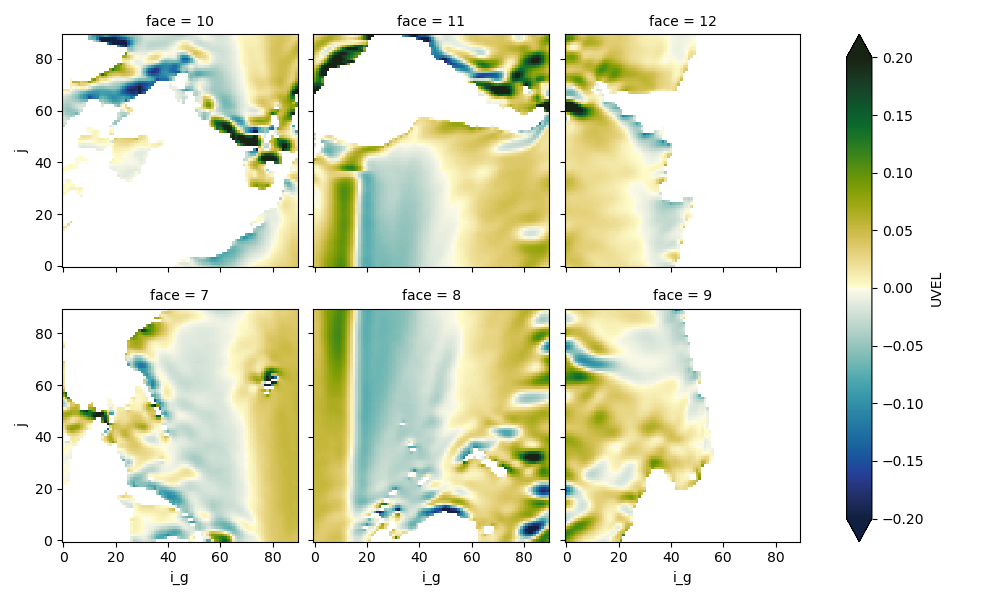

In [25]:
mytime = list(np.arange(10)+40)
ds = d07.isel(time=mytime).mean(dim='time')

vm=0.2
var = -ds.UVEL.isel(k=0,face=[10,11,12,7,8,9])
var.where(var!=0).plot(col='face',col_wrap=3,vmin=-vm,vmax=vm,cmap=cmo.delta)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
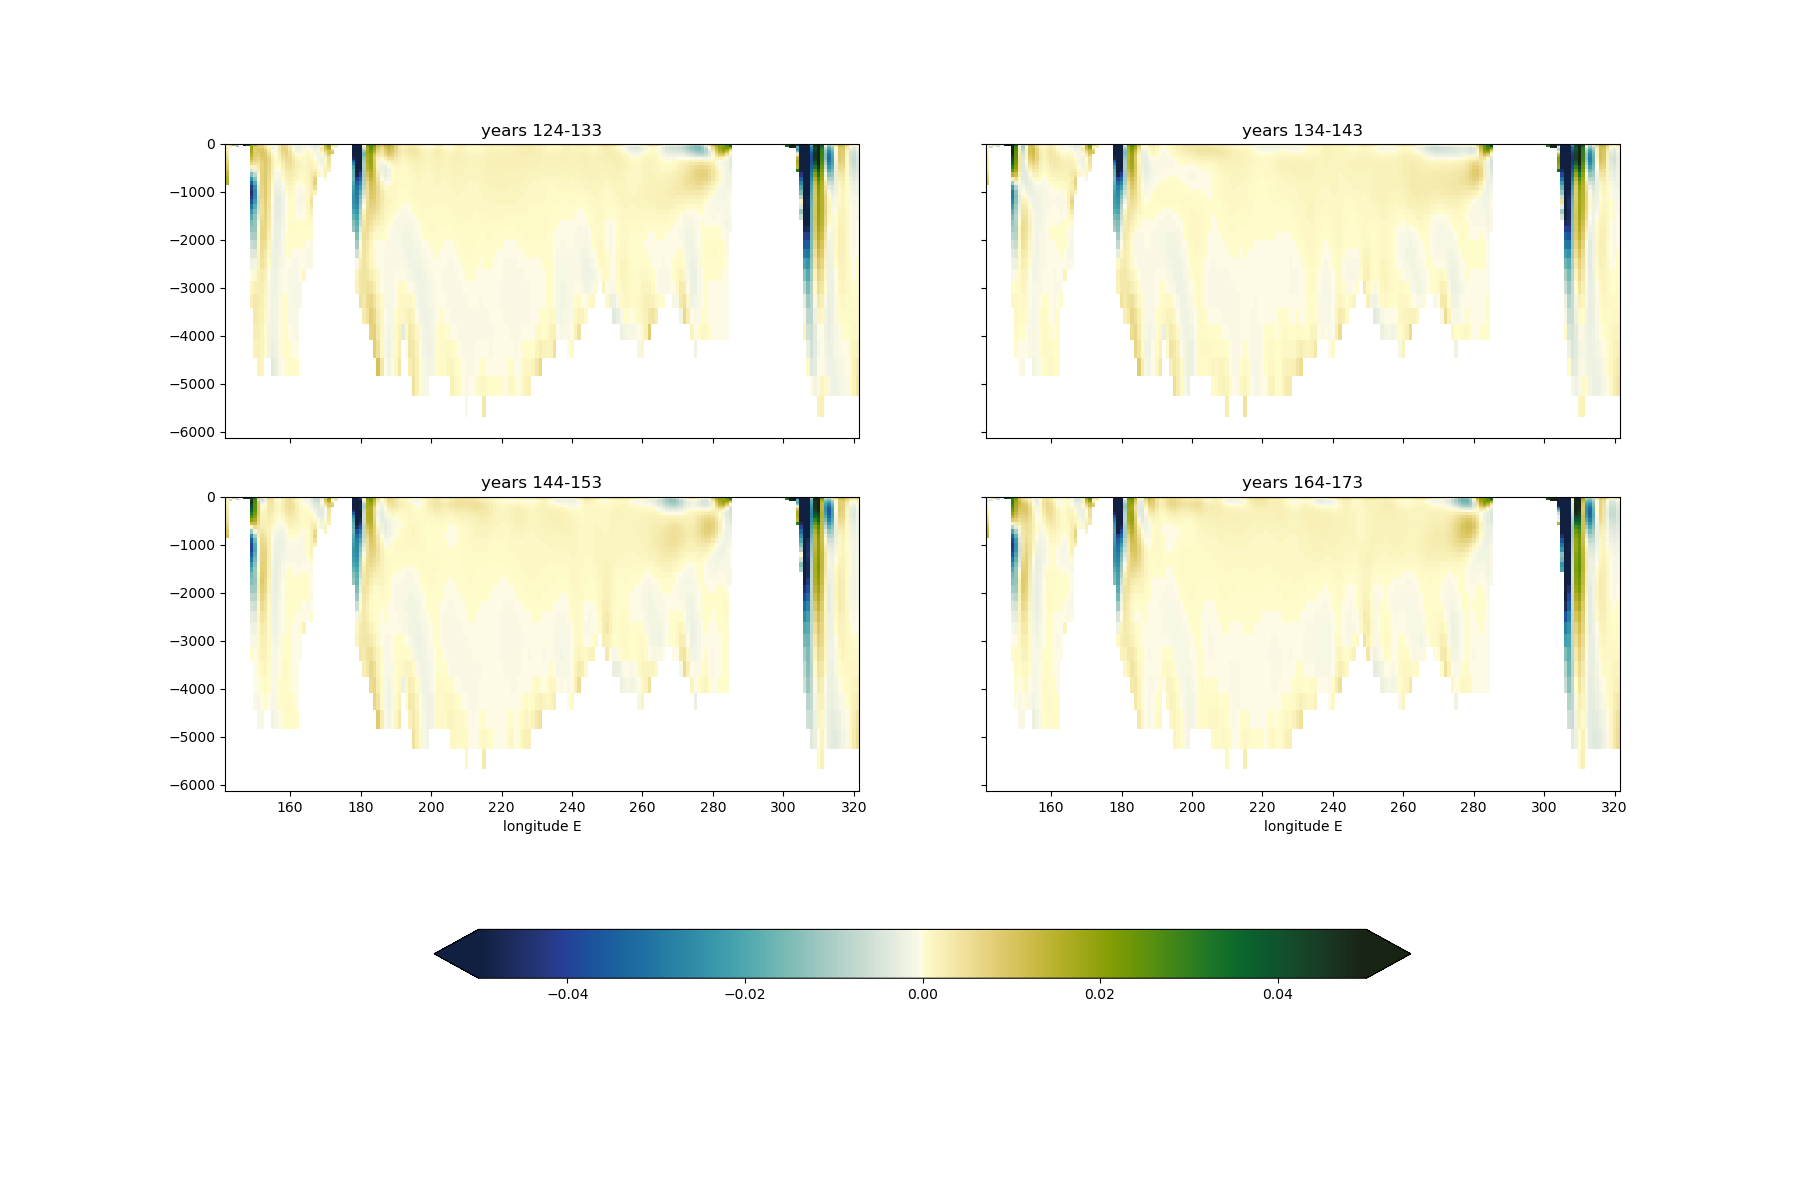

In [13]:
x = xr.concat([coords.XG.isel(face= 8),coords.XG.isel(face= 11)], dim='j_g')
y = xr.concat([coords.YC.isel(face= 8),coords.YC.isel(face= 11)], dim='j')
xs = np.where(x<0,x+360,x)
ii = 63
vm=5e-2

fig,ax=plt.subplots(2,2,figsize=(18,12),sharex=True,sharey=True);
ax=ax.ravel()
for k,y0 in enumerate([0,10,20,40]):
    mytime = list(np.arange(10)+y0+124)
    ds = d03.isel(time=mytime).mean(dim='time')
    var = -ds.UVEL*ds.dyG*ds.drF
    u = xr.concat([var.isel(face= 8),var.isel(face= 11)], dim='j')

    im = ax[k].pcolormesh(xs[:,ii],ds.Z,u.where(u!=0)[:,:,ii],vmin=-vm,vmax=vm,cmap=cmo.delta)
    ax[k].set_title('years %i-%i'%(mytime[0],mytime[-1]))
    
ax[-2].set_xlabel('longitude E')
ax[-1].set_xlabel('longitude E')

cb = fig.colorbar(im, ax=ax, orientation='horizontal',shrink = 0.7,extend='both')

In [60]:
ds = d03.isel(time=300) #.mean(dim='time')
var = -ds.UVEL*ds.dyG*ds.drF
ii=40
iz=37
u = xr.concat([var.isel(face= 8),var.isel(face= 11)], dim='j').compute()
var = ds.VVEL*ds.dxG*ds.drF
v = xr.concat([var.isel(face= 1),var.isel(face= 4)],dim='i').compute()
usum = u[:iz,:150,ii].sum().values*1e-6
vsum = v[:iz,ii+1,60:].sum().values*1e-6
print(usum,vsum, usum+vsum)
usum = u[iz:,:150,ii].sum().values*1e-6
vsum = v[iz:,ii+1,60:].sum().values*1e-6
print(usum,vsum, usum+vsum)
usum = u[:,:150,ii].sum().values*1e-6
vsum = v[:,ii+1,60:].sum().values*1e-6
print(usum,vsum, usum+vsum)

9.173789 -12.055216999999999 -2.8814279999999997
3.2397185 1.58909375 4.82881225
12.413507 -10.466123999999999 1.9473830000000003


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
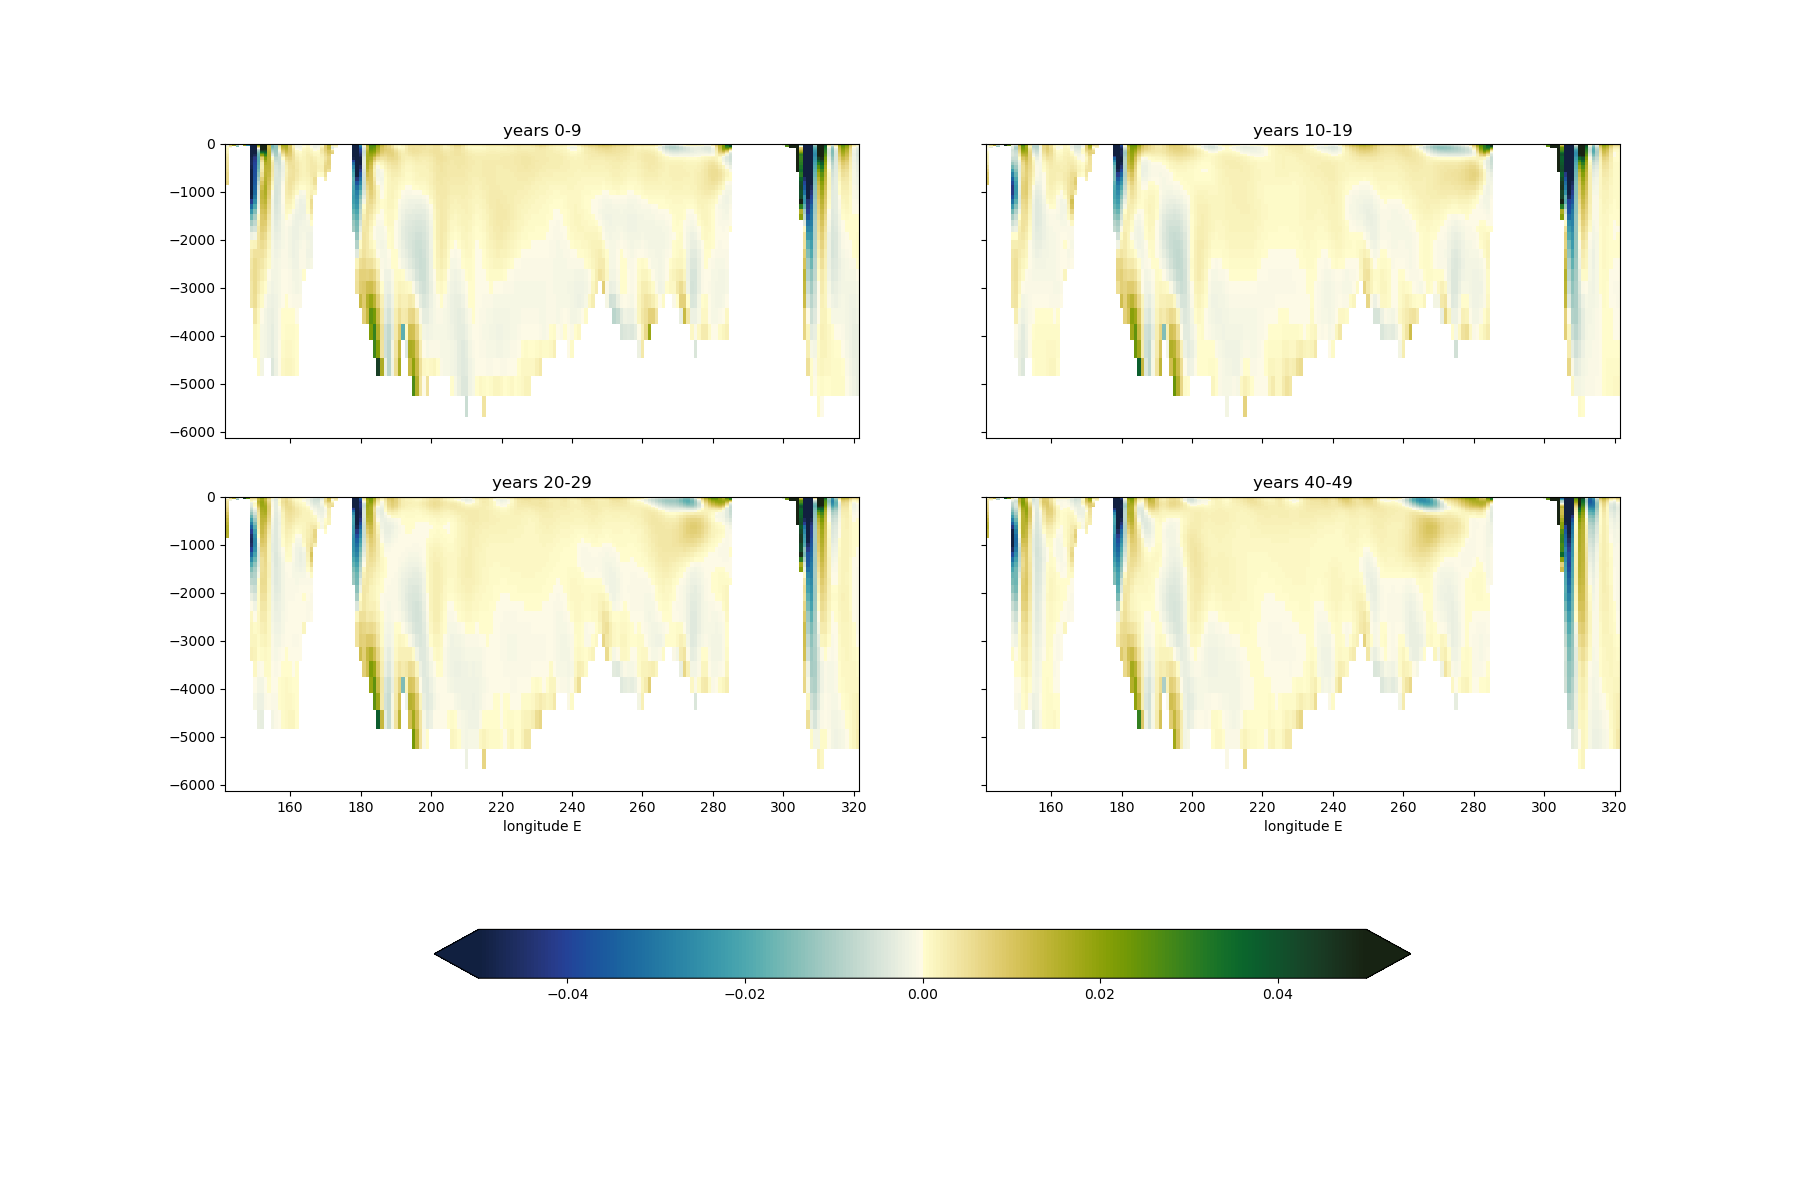

In [27]:
x = xr.concat([coords.XG.isel(face= 8),coords.XG.isel(face= 11)], dim='j_g')
y = xr.concat([coords.YC.isel(face= 8),coords.YC.isel(face= 11)], dim='j')
xs = np.where(x<0,x+360,x)
ii = 63
vm=5e-2

fig,ax=plt.subplots(2,2,figsize=(18,12),sharex=True,sharey=True);
ax=ax.ravel()
for k,y0 in enumerate([0,10,20,40]):
    mytime = list(np.arange(10)+y0)
    ds = d03.isel(time=mytime).mean(dim='time')
    var = -ds.UVEL
    u = xr.concat([var.isel(face= 8),var.isel(face= 11)], dim='j')

    im = ax[k].pcolormesh(xs[:,ii],ds.Z,u.where(u!=0)[:,:,ii],vmin=-vm,vmax=vm,cmap=cmo.delta)
    ax[k].set_title('years %i-%i'%(mytime[0],mytime[-1]))
    
ax[-2].set_xlabel('longitude E')
ax[-1].set_xlabel('longitude E')

cb = fig.colorbar(im, ax=ax, orientation='horizontal',shrink = 0.7,extend='both')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
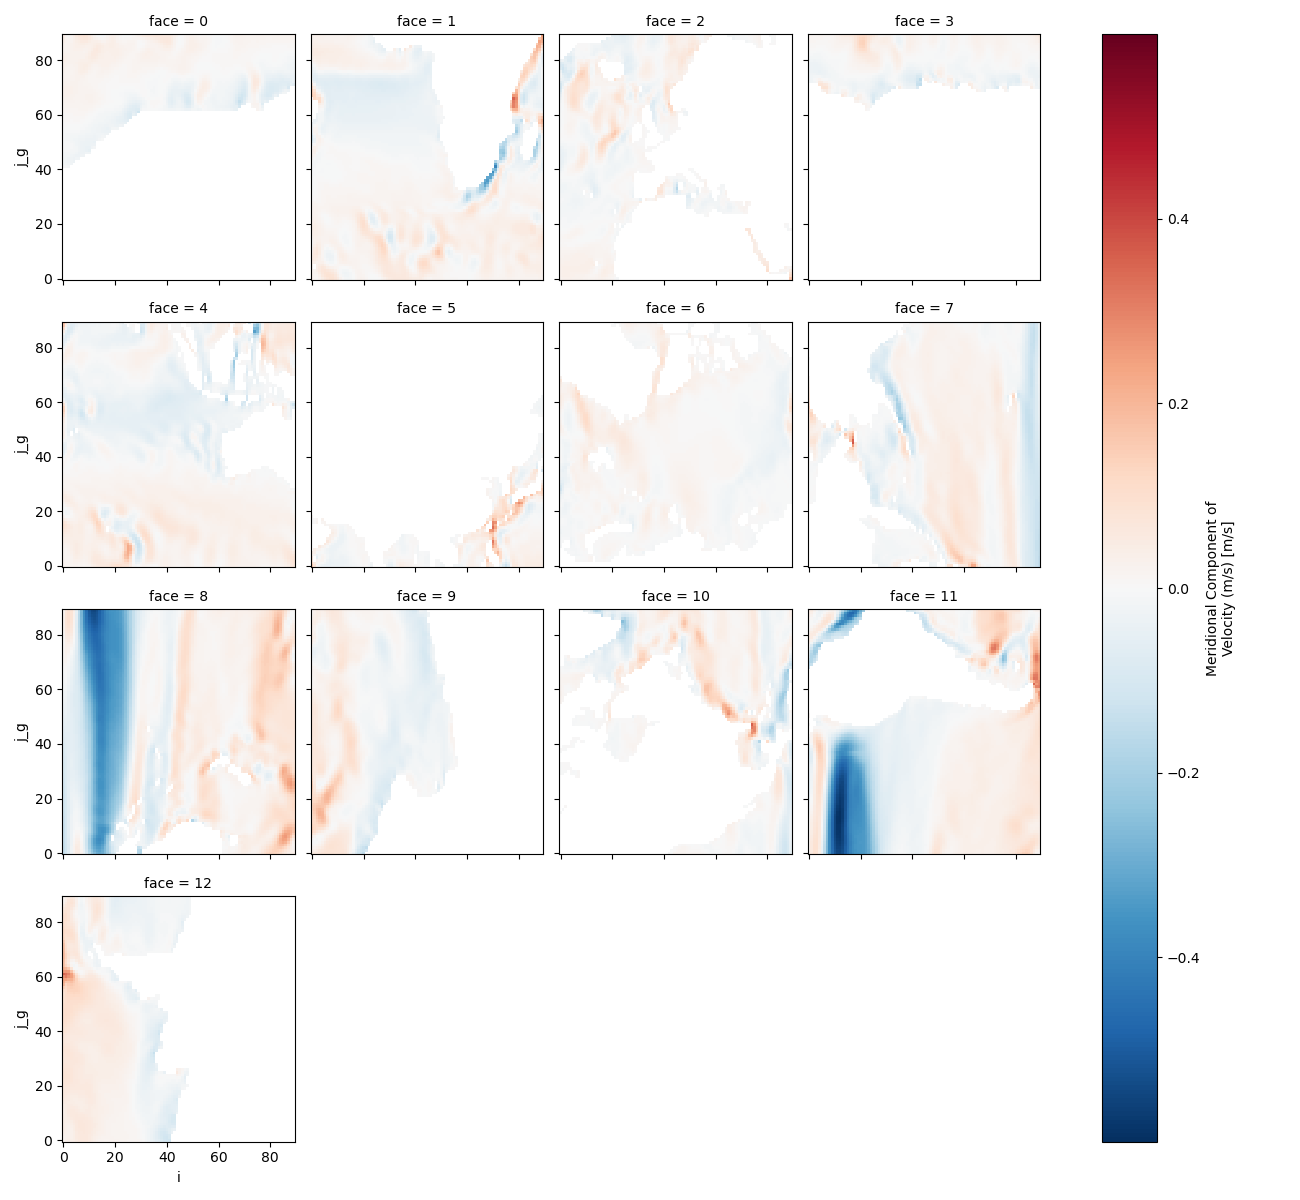

In [61]:
v = ds.VVEL.isel(k=1)
v.where(v!=0).plot(col='face',col_wrap=4)

In [73]:
ds = d03.isel(time=300)
var = ds.VVEL*ds.dxG*ds.drF
var.isel(face=4,j_g=68)[:,50:].sum().values*1e-6

-9.786798

In [63]:
def plotmoc_z(ax,ds,dl,msk,tstr='dummy'):
    psir = compute_moc_layers(dl6m,msk)
    sigma2 = zonal_mean(d06,d06m,msk)
    # interpolation
    # it is cheaper to define the interpolator once and only use part of
    # it than to define a new one for each latitude
    f = interp1d(dl.layer_1RHO_center, psir, axis=0,
                 bounds_error = False, fill_value=0)
    yy = flat2d(grid.YC)
    psir_z = np.zeros(sigma2.shape)
    for jj in range(psir.shape[1]):
        psir_z[:,jj] = f(sigma2[:,jj].data)[:,jj]

    dd = flat2d(ds.Depth*msk)
    d = dd.max(axis=-1)
    y = yy.mean(axis=-1)
    #y = np.arange(y.shape[0])
    #csf=ax.pcolormesh(y,ds.Zu,sq(mocstrf),norm=symNorm(20),cmap=cmo.curl)#,vmin=-20,vmax=20)
    csf=ax.contourf(y,ds.Zu,sq(psir_z)*1e-6,levels=np.linspace(-20,20,41),cmap=cmo.curl, extend='both')
    ax.fill_between(y,-d,-ds.drF.sum()-200,step='mid',facecolor='lightgrey')
    plt.colorbar(csf,ax=ax,orientation='horizontal',extend='both')
    ax.set_title('%s'%(tstr))
    ax.axis('tight')
    ax.grid()

compute averages first

In [44]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)
dl6m = dl6.isel(time=range(22,62)).mean(dim='time').compute()
d06m = d06.isel(time=np.arange(22,62)+248).LaTr1RHO.mean(dim='time').compute()

In [49]:
msk = atlantic_mask
psir = compute_moc_layers(dl6m,msk)
sigma2 = zonal_mean(d06,d06m,msk)

In [50]:
from scipy.interpolate import interp1d

# it is cheaper to define the interpolator once and only use part of
# it than to define a new one for each latitude
f = interp1d(dl6.layer_1RHO_center, psir, axis=0,
             bounds_error = False, fill_value=0)

In [51]:
psir_z = np.zeros(sigma2.shape)
for jj in range(psir.shape[1]):
    psir_z[:,jj] = f(sigma2[:,jj].data)[:,jj]

psir_z.shape

(50, 270)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
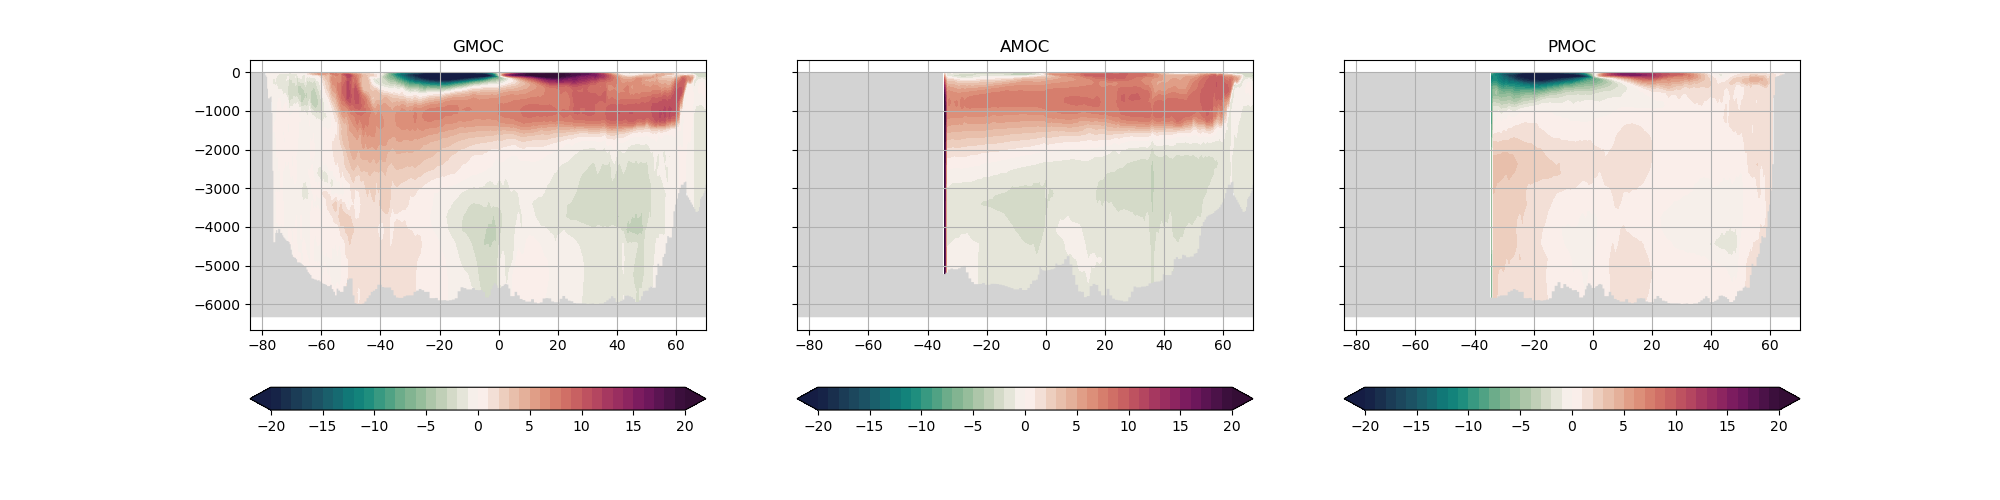

In [65]:
plt.close()
fig, ax = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(20,5))#, subplot_kw={'projection': proj})
ax = ax.ravel()
pfac = 1e-6
plotmoc_z(ax[0],d06,dl6,global_mask,tstr = 'GMOC')
plotmoc_z(ax[1],d06,dl6,atlantic_mask,tstr = 'AMOC')
plotmoc_z(ax[2],d06,dl6,indopacific_mask,tstr = 'PMOC')

In [33]:
sigma2.data

array([[ 0.      ,  0.      ,  0.      , ..., 35.467697, 35.41381 ,
        35.420864],
       [ 0.      ,  0.      ,  0.      , ..., 35.557537, 35.50566 ,
        35.512825],
       [ 0.      ,  0.      ,  0.      , ..., 35.663727, 35.607353,
        35.61416 ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [68]:
d06

<xarray.Dataset>
Dimensions:               (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50, k_p1: 51, face: 13, l1_b: 89, l1_c: 88, l1_i: 87, time: 310)
Coordinates: (12/51)
  * i                     (i) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i_g                   (i_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * j                     (j) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * j_g                   (j_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * k                     (k) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * k_u                   (k_u) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
    ...                    ...
    rhoRef                (k) >f4 dask.array<chunksize=(50,), meta=np.ndarray>
    layer_1RHO_bounds     (l1_b) >f4 dask.array<chunksize=(89,), meta=np.ndarray>
    layer_1RHO_center     (l1_c) float32 dask.array<chunksize=(88,), meta=np.ndarray>
    layer_1RHO_interface  (l1_i) >f4 dask.array<chunksize=(87,), meta=np.ndarray>
    iter                  (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1711-01-01 ... 2020-01-01
Data variables:
    ETAN                  (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    MXLDEPTH              (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    oceFWflx              (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    oceQnet               (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    THETA                 (time, k, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    SALT                  (time, k, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    DRHODR                (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    UVEL                  (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    VVEL                  (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    WVEL                  (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    LaTr1RHO              (time, k, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

In [156]:
fw=d06.oceFWflx
hf=d06.oceQnet
fw=fw.where(d06.hFacC[0,:,:]!=0)
hf=hf.where(d06.hFacC[0,:,:]!=0)

fwm = fw.isel(time=np.arange(62)+248).mean(dim='time').compute()
hfm = hf.isel(time=np.arange(62)+248).mean(dim='time').compute()

Text(0.5, 1.0, 'net fresh water flux into ocean (+ down), > 0 decreases salinity (kg / m^2 / s)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
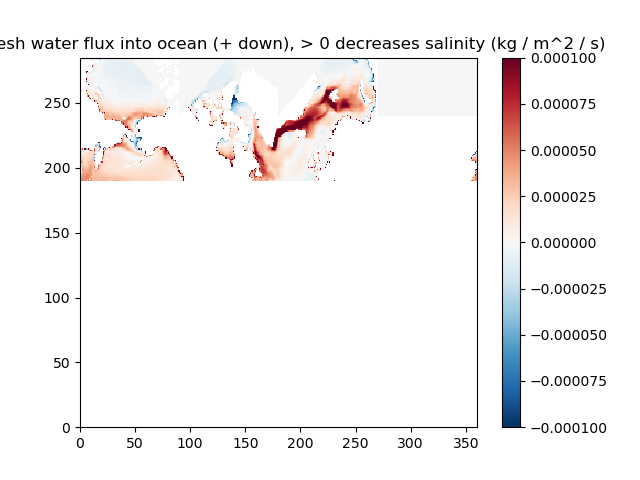

In [151]:
plt.close(); plt.figure()
#fw.isel(time=-1,face=6).plot(vmin=-1e-4,vmax=1e-4,cmap=cmo.delta)
#fw.isel(time=-1).plot(col='face',col_wrap=5,vmin=-1e-4,vmax=1e-4)
#plt.pcolormesh(mosaic_llc(fw.isel(time=-1)),vmin=-1e-4,vmax=1e-4, cmap=cmo.delta)
plt.pcolormesh(mosaic_llc(fwm.where(coords.YC>45)),vmin=-1e-4,vmax=1e-4, cmap=cm.RdBu_r)

plt.colorbar()
plt.title('net fresh water flux into ocean (+ down), > 0 decreases salinity (kg / m^2 / s)')

In [154]:
#(fw*coords.rA*coords.hFacC[0,:,:]).isel(time=62*5-1).where(coords.YC>45).sum().values / 1000 * 1e-6
(fwm*coords.rA*coords.hFacC[0,:,:]).sum().values / 1000 * 1e-6

-2.9184e-05

In [116]:
2.4615446e+08*1e-6/1000

0.24615446

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
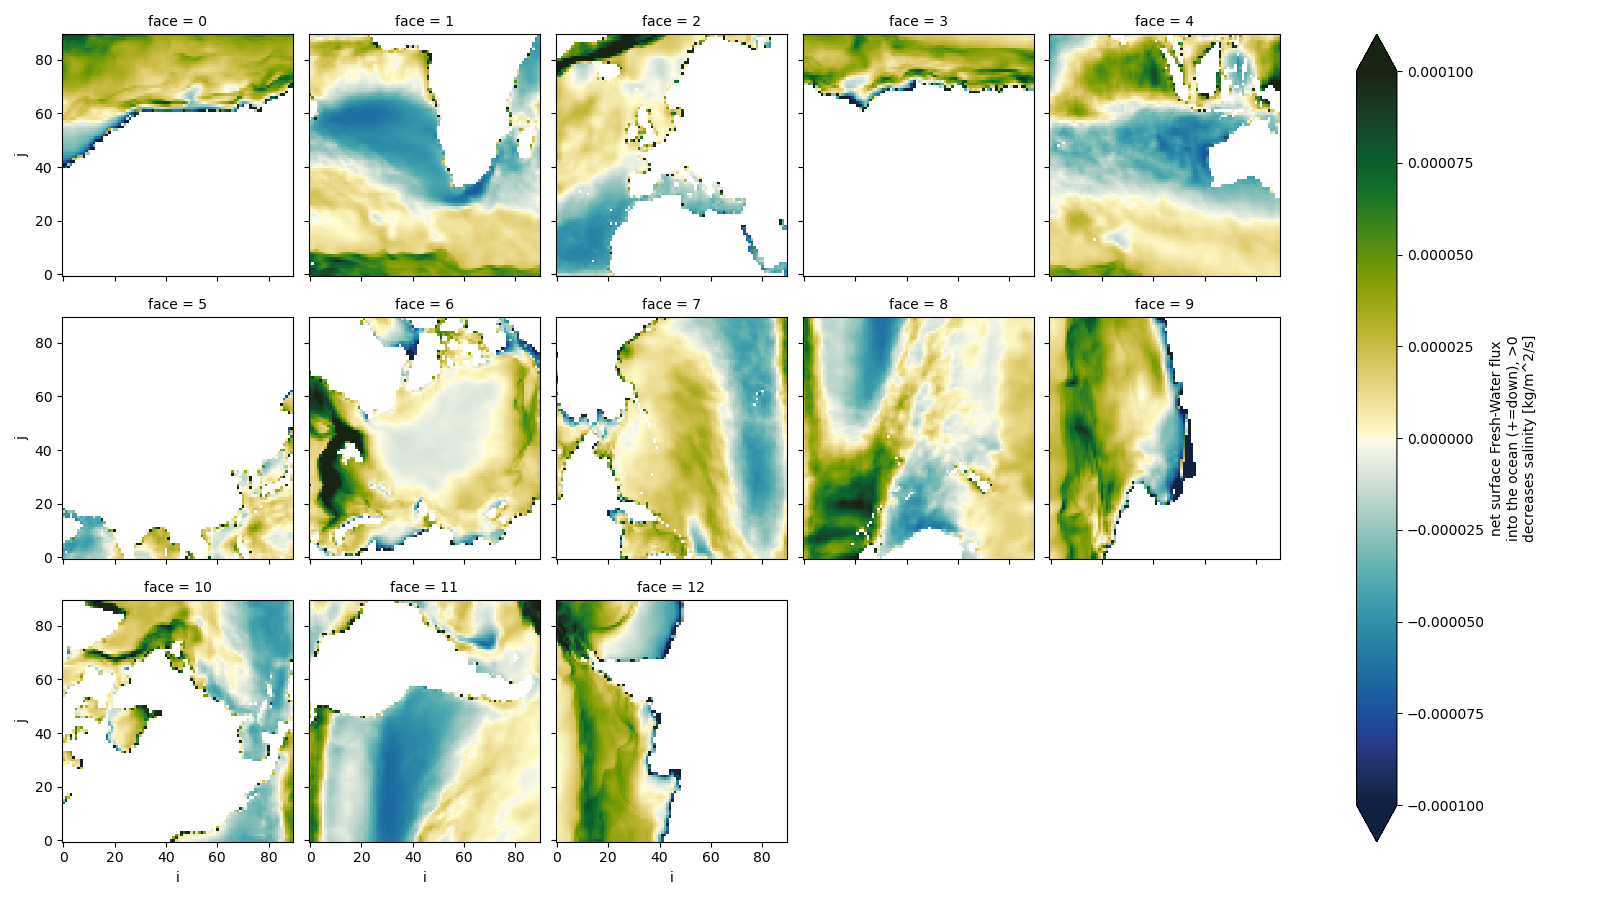

In [132]:
fw.isel(time=-1).plot(col='face',col_wrap=5,vmin=-1e-4,vmax=1e-4,cmap=cmo.delta)

In [163]:
k=2
dm06 = open_mdsdataset(rdirs[k],prefix=['diags2DMonthly'],delta_t=deltats[k],ref_date=refdate,geometry='llc')
# fix coordinates
dm06.coords['XC'] = grid.XC
dm06.coords['YC'] = grid.YC
dm06.coords['XG'] = grid.XG
dm06.coords['YG'] = grid.YG

In [171]:
#monthlyClim = dm06.sel(time=slice(1980,2020)).groupby('time.month').mean(dim='time')
monthlyClim = dm06.groupby('time.month').mean(dim='time')
#dm06.time

<GeoAxesSubplot:title={'center':'ice thickness in September (m)'}>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
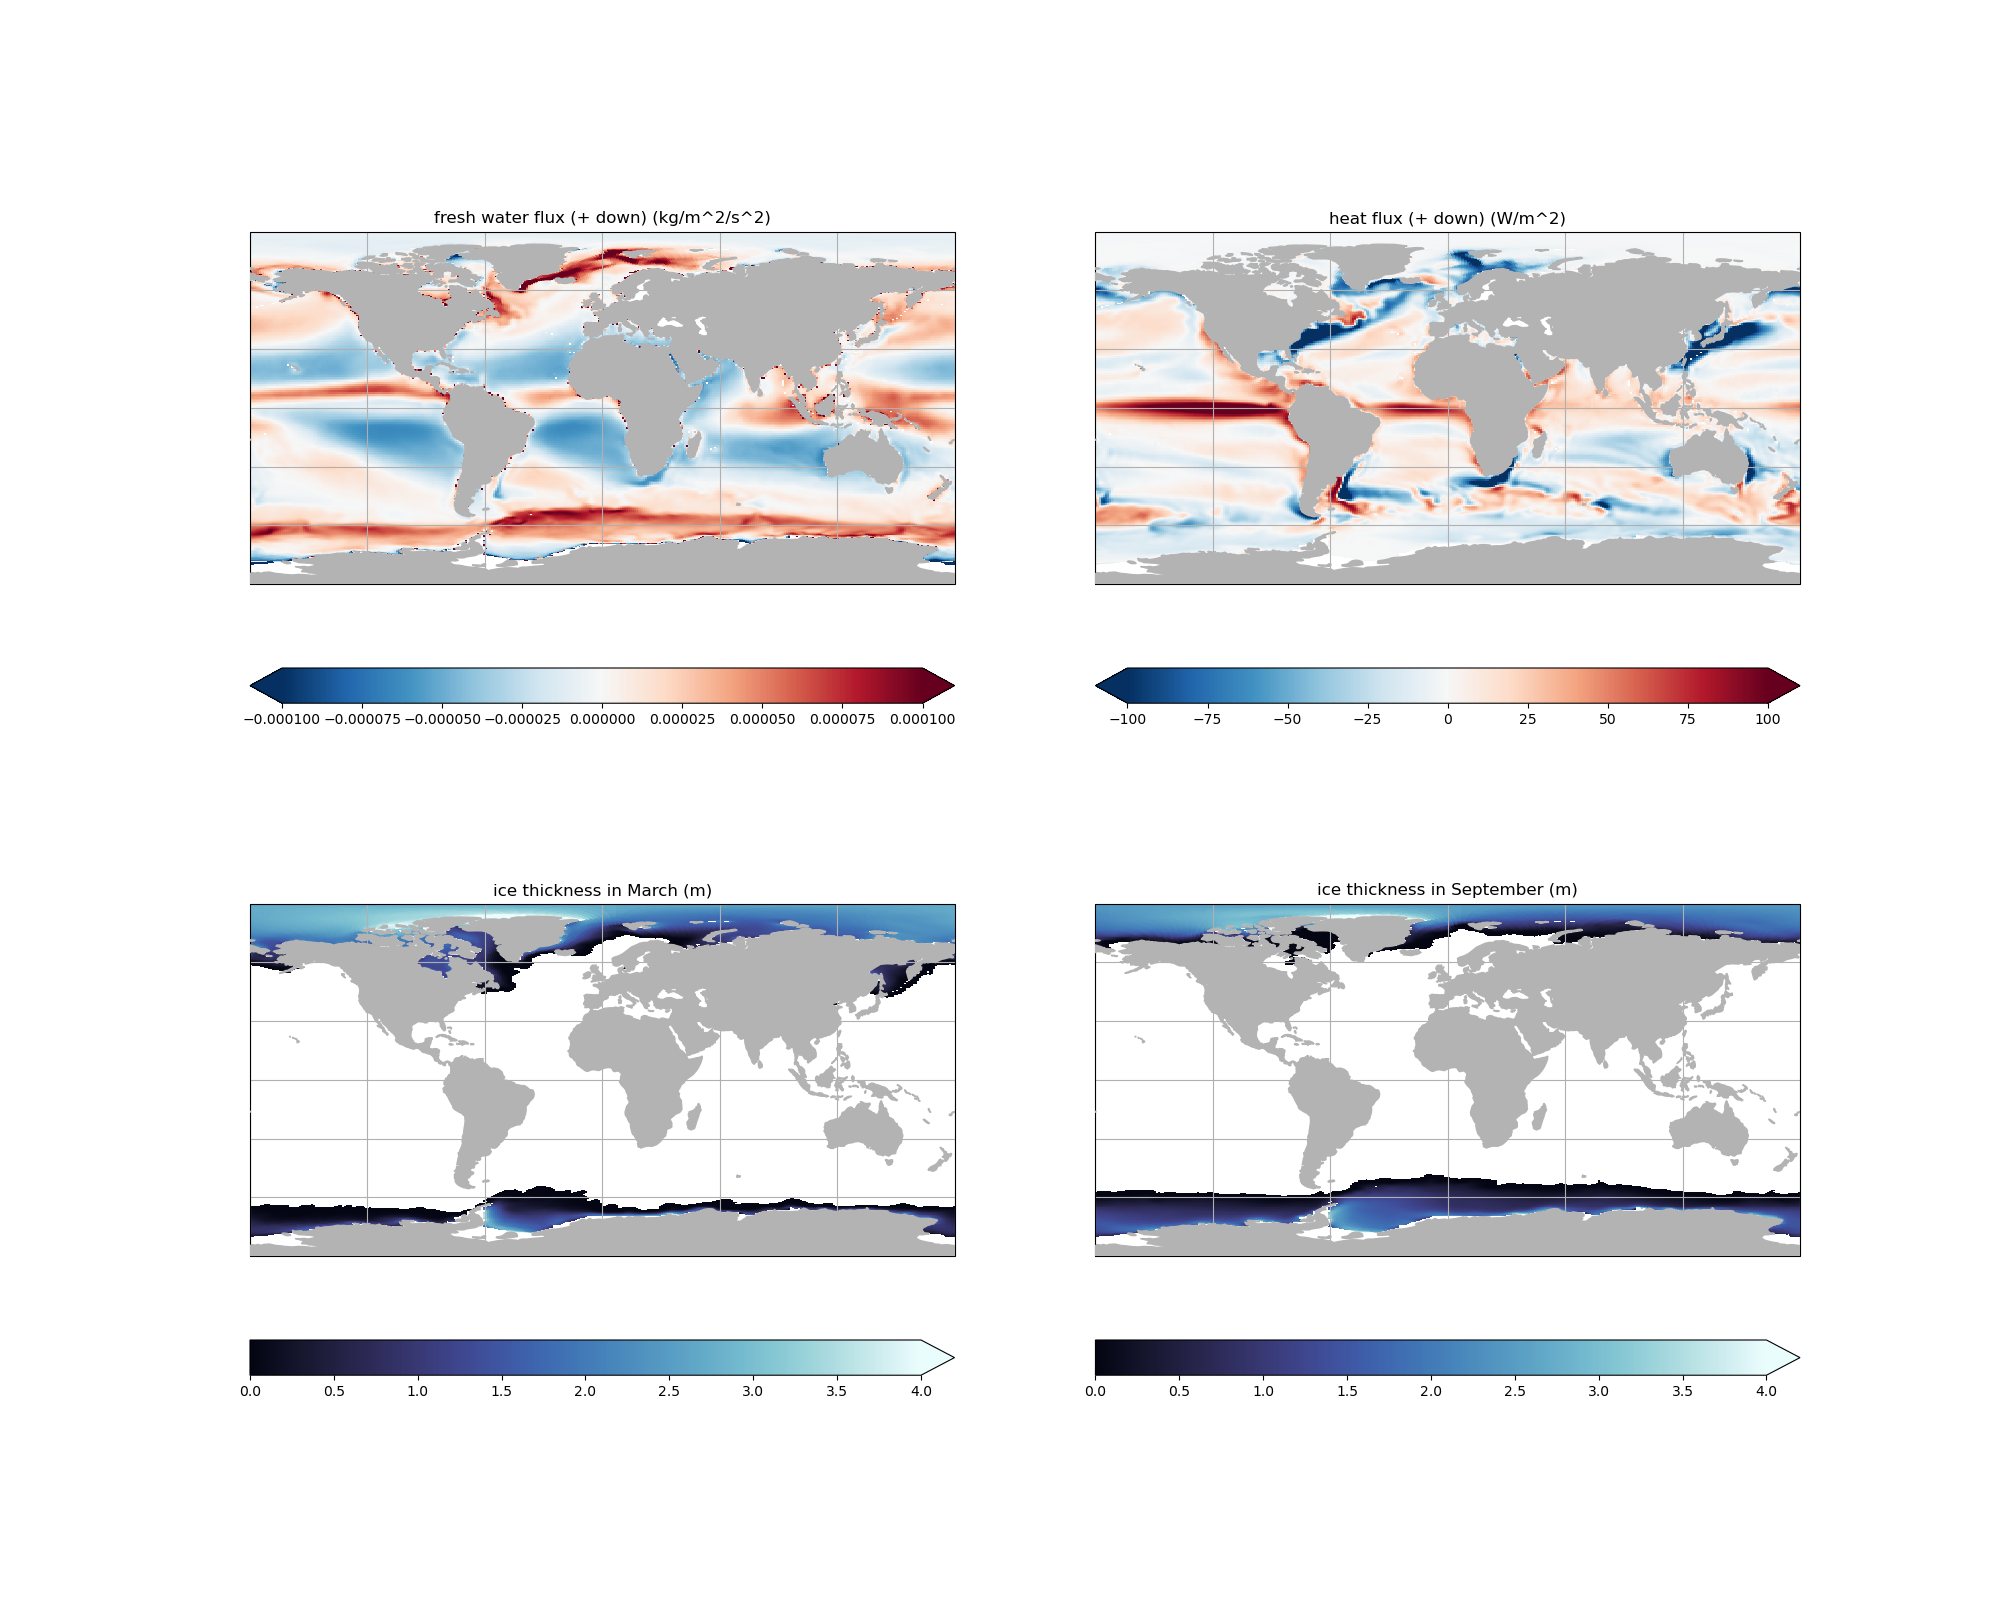

In [177]:
plt.close()
proj=cart.crs.Robinson()#central_longitude=180.0-19) #central_longitude=7.0)
proj=cart.crs.PlateCarree(central_longitude=0.0)


mapper = LLCMapper(coords) #, dx=1., dy=1.)
mask2d=(d06.hFacC.isel(k=0)!=0.).compute()

fig, ax = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True,figsize=(20,16),subplot_kw={'projection': proj})

ax = ax.flatten()

mytime=-1
mlnorm = colors.Normalize(vmin=0,vmax=1000)
enorm = colors.Normalize(vmin=-3,vmax=2)

mapper(fwm,ax=ax[0],norm=colors.Normalize(vmin=-1e-4,vmax=1e-4),cmap=cm.RdBu_r,tstr='fresh water flux (+ down) (kg/m^2/s^2)')
mapper(hfm,ax=ax[1],norm=colors.Normalize(vmin=-100.,vmax=100.),cmap=cm.RdBu_r,tstr='heat flux (+ down) (W/m^2)')

heffm = monthlyClim.sel(month=3).SIheff
heffs = monthlyClim.sel(month=9).SIheff
mapper(heffm.where(heffm>0),ax=ax[2],norm=colors.Normalize(vmin=0.,vmax=4.),cmap=cmo.ice,tstr='ice thickness in March (m)')
mapper(heffs.where(heffs>0),ax=ax[3],norm=colors.Normalize(vmin=0.,vmax=4.),cmap=cmo.ice,tstr='ice thickness in September (m)')


#dmlnorm = colors.Normalize(vmin=-100,vmax=100)
#mapper((dss[0]-dss[1]).isel(time=mytime).MXLDEPTH.where(mask2d),ax=ax[4],norm=dmlnorm,cmap=cmo.delta,tstr='%s - %s: MLD(md)'%(rnames[0],rnames[1]))

In [13]:
def plotsec30(ax,ds,fld,cnorm,tstr='dummy',cmap=None):
    ii=7
    iface=3
    fld0=np.concatenate((fld[:,0,:,ii],fld[:,1,:,ii],fld[:,2,:,ii]),axis=1)
    y = np.concatenate((ds.YC[0,:,ii],ds.YC[1,:,ii],ds.YC[2,:,ii]),axis=0)
    d = np.concatenate(ds.Depth[:iface,:,ii],axis=0)
    csf=ax.pcolormesh(y,ds.Z,fld0,norm=cnorm,cmap=cmap)
#    ax.fill_between(y,-d,-ds.Depth.max(),step='mid',facecolor='lightgrey')
    plt.colorbar(csf,ax=ax,orientation='vertical')
    ax.set_title('%s, section along %i E'%(tstr,ds.XC.sel(face=1,i=ii).mean()))

def plotsec170(ax,ds,fld,cnorm,tstr='dummy',cmap=None):
    jj=47
    fld0=np.concatenate((fld[:,7,jj,:],fld[:,8,jj,:],fld[:,9,jj,:]),axis=1)
    y = np.concatenate((ds.YC[7,jj,:],ds.YC[8,jj,:],ds.YC[9,jj,:]),axis=0)
    d = np.concatenate(ds.Depth[7:10,jj,:],axis=0)
    csf=ax.pcolormesh(y,ds.Z,fld0,norm=cnorm,cmap=cmap)
#    ax.fill_between(y,-d,-ds.Depth.max(),step='mid',facecolor='lightgrey')
    plt.colorbar(csf,ax=ax,orientation='vertical')
    ax.set_title('%s, section along %i E'%(tstr,ds.XC.sel(face=8,j=jj).mean()))

Text(0.5, 0.98, 'difference between 1952 and 1711')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
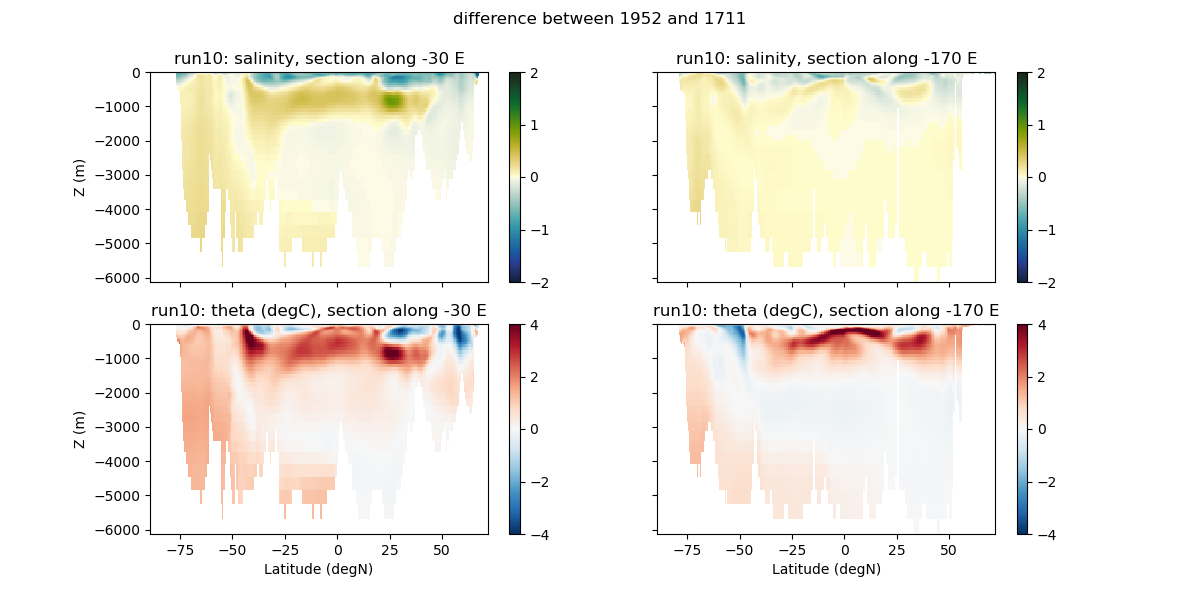

In [53]:
plt.close()
mytime=-1
k = 2
#fig,ax=plt.subplots(2,2,figsize=(18,9),sharex=True,sharey=True);
fig,ax=plt.subplots(2,2,figsize=(12,6),sharex=True,sharey=True);
ds = d06.isel(time=mytime) - d06.isel(time=0)
msk = d06.hFacC.where(ds.hFacC>0).values
msk[msk>0]=1

myfld = ds.SALT*msk
salt = myfld.where(myfld!=0).values
cnorm = colors.Normalize(34,36); cmap=cmo.haline
cnorm = colors.Normalize(-2,2); cmap=cmo.delta
plotsec30( ax[0,0],ds,salt,cnorm,'%s: salinity'%(rnames[k]),cmap=cmap)
plotsec170(ax[0,1],ds,salt,cnorm,'%s: salinity'%(rnames[k]),cmap=cmap)

myfld = ds.THETA*msk
theta = myfld.where(myfld!=0).values
cnorm = colors.Normalize(-1,3); cmap = cmo.thermal
cnorm = colors.Normalize(-4,4); cmap = cm.RdBu_r
plotsec30( ax[1,0],ds,theta,cnorm,'%s: theta (degC)'%(rnames[k]),cmap=cmap)
plotsec170(ax[1,1],ds,theta,cnorm,'%s: theta (degC)'%(rnames[k]),cmap=cmap)


for b in ax[1,:]: b.set_xlabel('Latitude (degN)')
for b in ax[:,0]: b.set_ylabel('Z (m)')

thisyear=np.datetime_as_string(d06.time.isel(time=mytime), unit='Y')
#fig.suptitle('year %s'%(thisyear))
fig.suptitle('difference between %s and 1711'%(thisyear))
#fig.savefig(os.path.join(fdir,'prandlt_number_sections_y%s'%(thisyear)),dpi=300)

In [43]:
k=2
msk = d06.hFacC.where(ds.hFacC>0).values
msk[msk>0]=1

fdir = '/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs'

for mytime in range(1,310):

    fig,ax=plt.subplots(2,2,figsize=(12,6),sharex=True,sharey=True);

    ds = d06.isel(time=mytime) - d06.isel(time=0)

    myfld = ds.SALT*msk
    salt = myfld.where(myfld!=0).values
    cnorm = colors.Normalize(-2,2); cmap=cmo.delta
    plotsec30( ax[0,0],ds,salt,cnorm,'%s: salinity'%(rnames[k]),cmap=cmap)
    plotsec170(ax[0,1],ds,salt,cnorm,'%s: salinity'%(rnames[k]),cmap=cmap)

    myfld = ds.THETA*msk
    theta = myfld.where(myfld!=0).values
    cnorm = colors.Normalize(-4,4); cmap = cm.RdBu_r
    plotsec30( ax[1,0],ds,theta,cnorm,'%s: theta (degC)'%(rnames[k]),cmap=cmap)
    plotsec170(ax[1,1],ds,theta,cnorm,'%s: theta (degC)'%(rnames[k]),cmap=cmap)

    for b in ax[1,:]: b.set_xlabel('Latitude (degN)')
    for b in ax[:,0]: b.set_ylabel('Z (m)')

    thisyear=np.datetime_as_string(d06.time.isel(time=mytime), unit='Y')
    print(thisyear)
    fig.suptitle('difference between %s and 1711'%(thisyear))
    fig.savefig(os.path.join(fdir,'sectionDiff%s_1711.png'%(thisyear)),dpi=300)
    plt.close(fig)

1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1772
1773
1775
1776
1776
1777
1779
1780
1780
1781
1783
1784
1784
1785
1787
1788
1788
1789
1791
1792
1792
1793
1795
1796
1796
1797
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1896
1897
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911


In [11]:
dl=dl6 #.isel(time=-1)
grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)
# # layer flux in two directions
# flxx = dl.LaUH1RHO*dl.dyG
# flxy = dl.LaVH1RHO*dl.dxG
# # difference in the x and y directions
# diff_flx = grd.diff_2d_vector({'X': flxx, 'Y': flxy}, boundary='fill')
# # divergence
# flx_div = diff_flx['X'] + diff_flx['Y']
# wflux_dia = -flx_div.reindex(l1_c=flx_div.l1_c[::-1]).cumsum(dim='l1_c')/dl.rA
# #wflux_dia = calc_wflux_dia(dl6)/dl.rA

/home/ollie/mlosch/miniconda3/envs/mitgcm/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
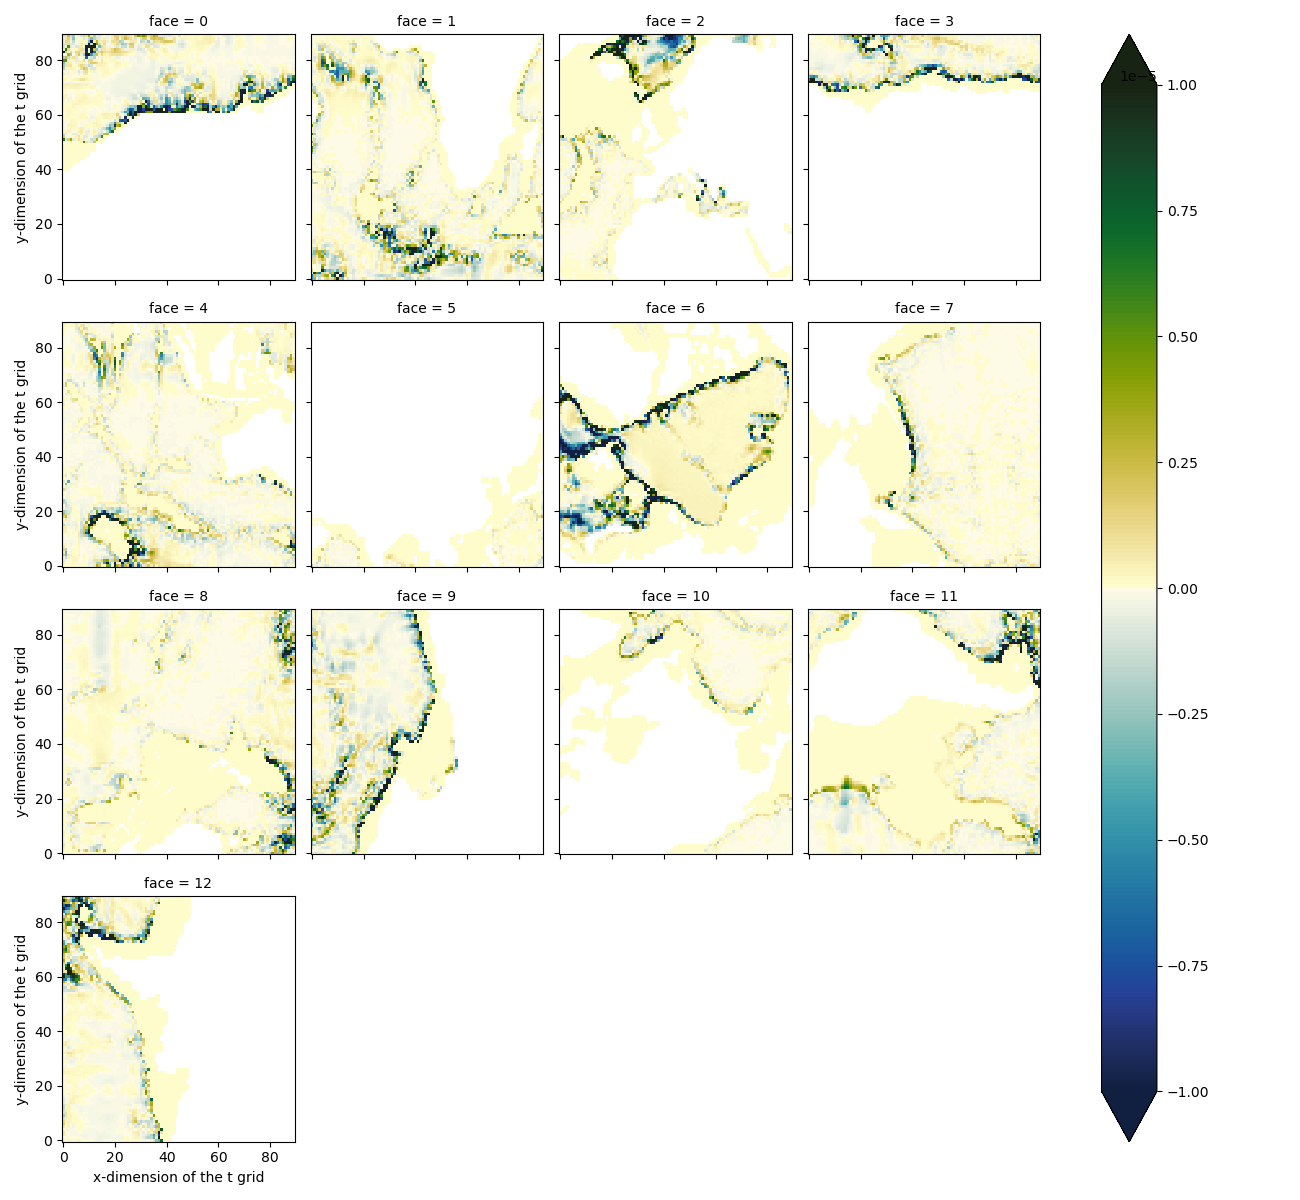

In [25]:
wflux_dia.isel(l1_c=40).mean(dim='time').where(dl6.hFacC.isel(k=0)>0).plot(col='face',col_wrap=4,vmin=-1e-5,vmax=1e-5,cmap=cmo.delta)

In [16]:
dl=dl6 #.isel(time=-1)

face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}


print(xgcm.__version__)

print(dl)
#print(face_connections)
#grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)
grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)

print(grd)

0.6.1
<xarray.Dataset>
Dimensions:               (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50, k_p1: 51, face: 13, l1_b: 89, l1_c: 88, l1_i: 87, time: 62)
Coordinates: (12/51)
  * i                     (i) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i_g                   (i_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * j                     (j) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * j_g                   (j_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * k                     (k) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * k_u                   (k_u) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
    ...                    ...
    dyU                   (face, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    layer_1RHO_bounds     (l1_b) >f4 dask.array<chunksize=(89,), meta=np.ndarray>
    layer_1RHO_center     (l1_c) float32 dask.array<chunksize=(88,), meta=np.ndarray>
    layer_1RHO_interface  (l1_i) >f4 d

<GeoAxesSubplot:title={'center':'msk'}>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
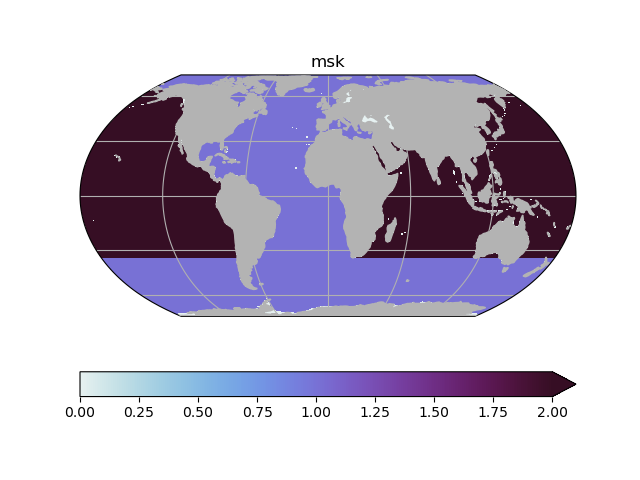

In [14]:
proj=cart.crs.EqualEarth()#central_longitude=180.0-19) #central_longitude=7.0)

mapper = LLCMapper(coords) #, dx=1., dy=1.)

fig,ax=plt.subplots(1,1,subplot_kw={'projection': proj})
mapper(dss[0].hFacC[0,:,:]+indopacific_mask,ax=ax,norm=colors.Normalize(0,2),cmap=cmo.dense,tstr='msk')